---
$\LARGE \textbf{\textcolor{red}{xTB-crest Quantum Chemistry Calculations Assessment and Validation}}$

---
# **Molecular Simulation and Featurization Workflow and Goals of The Report**

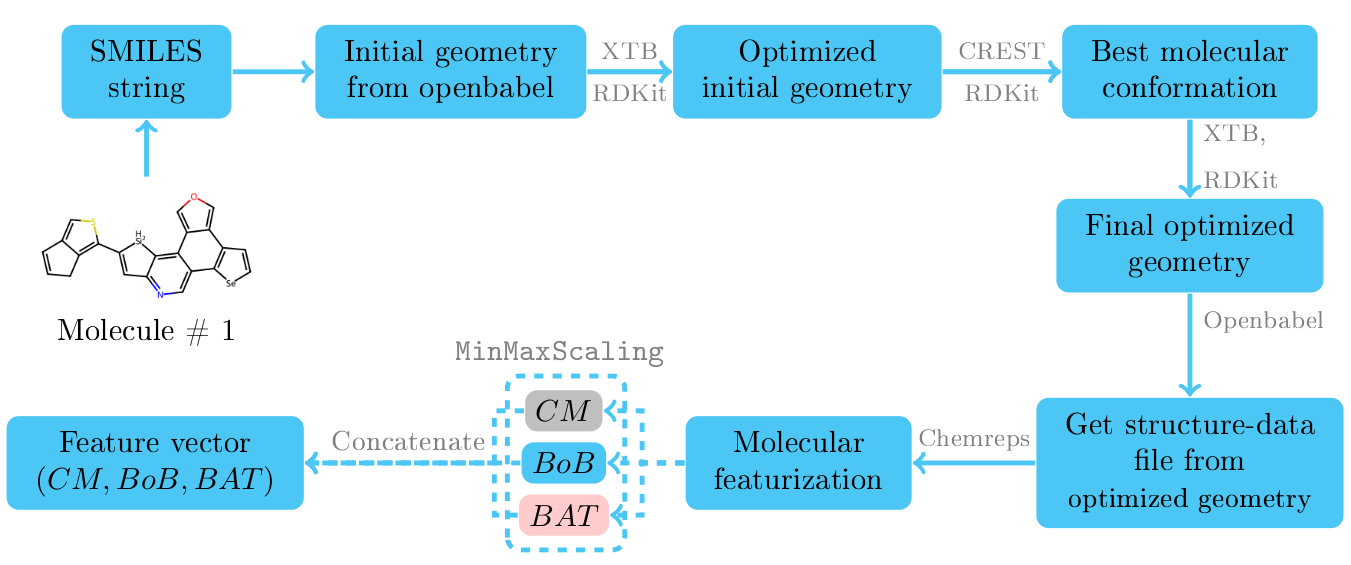

In [1]:
from IPython.display import Image
Image(filename='Workflow.png', format='png', width=1500, height=1500)

## **Problems encountered during workflow implementation**

In the course of implementing the flow chart presented above, which was inspired by the Tartarus design of organic photovoltaics <cite id="xgi9k"><a href="#zotero%7C9235801%2FCE7AEM4H">[1]</a></cite>, the following issues have been encountered: 

1. Failure in geometry pre-optimization process
2. Change in topology detected after input pre-optimization, as an artifact of the chosen `GFN` level of theory, resulting in abnormal termination of crest conformer search
3. `OpenBabel` failure when attempting to set stereochemistry, indicating that it was unable to identify an available bond

## **Troubleshooting Hypothesis**

In order to circumvent or definitely resolve the aforementioned issues, we intend to proceed as follows.

1. Failure in the pre-optimization process of geometry:
   
   - Add a **checkpoint** step at the end of each structure pre-optimization to ascertain wether the task has been successfully completed.
   - In the event that the output from the checkpoint is negative, switch to another `GFN-xTB` level of theory (either $0$, $1$, or $2$, depending on the previous choice) and run back the pre-optimization process.
   - Should all the `GFN-xTB` levels of theory result in the abnormal termination of `xTB`, definitely remove the molecular sample from the dataset
  
2. Topology change after pre-optimization in comparison to the 3D input structure generated with OpenBabel:

   - Add a **checkpoint** step at the end of each conformer search process to inquire if the task has been successfully achieved or not.
   - If the output from the checkpoint is negative, switch to another `GFN-xTB` level of theory (either $0$, $1$, or $2$, depending on the previous choice) and run the pre-optimization anew.
   - In the event that all of the `GFN-xTB` levels of theory lead to the abnormal termination of `xTB`, definitely remove the molecular sample from the dataset

3. `OpenBabel` failure in handling the 3D arrangement of atoms around a particular bond, for accurately capturing the spatial configuration of the molecule:

   - In case the molecular file conversion from `.xyz` to `.sdf` yields this warning, check if the `xTB` optimization process has generated a `.mol` file that provides a more complete representation of the stereochemistry. Indeed, the consistency of the input XYZ file or slow convergence between iterations, often due to molecular complexity or convergence criteria setup, may result in `xTB` generating `.mol` files.
   - If **Yes**, convert the `.mol` file to `.sdf` instead of the `.xyz`, as the latter incorporates more stereochemistry information.
   - Alternatively, if the answer is **No**, remove the molecule from the dataset to avoid involving molecules with an incorrect spatial configuration in subsequent analysis steps. 
  
In order for the hypotheses we have formulated to be subjected to further analysis, it is essential that we:

* Assess the reliability of the molecular structures generated by the `xTB`-`crest` tandem.
* Provide a concise overview of the processing and structural details associated with each level of theory employed by the `xTB`-`crest` tandem.
   

---
# **Validation of Molecular Structures Obtained from The `xTB`-`crest` Tandem**

In order to evaluate the workflow involving the `xTB`-`crest` tandem, a benchmarking exercise will be conducted using Cartesian coordinates obtained from the `Corina`-`PM7`-`B3LYP`. The focus will be on the quantum chemistry (QC) results, specifically the HOMO, LUMO, and Gap, which have been modelled using B3LYP/$6-31+G(2df,p) based DFT <cite id="3rn6k"><a href="#zotero%7C9235801%2FR4KPWEEQ">[2]</a></cite>. The following procedure will be followed:

1. Collect $15$ `QM9` molecular SMILES
2. Generate initial 3D Cartesian coordinates  with `OpenBabel`
3. Preoptimize the input structure using `xTB` ($0$, $1$ and $2$ `xTB-GFN` levels of Theory)
4. Perform conformer search with `crest` ($0$, $1$ and $2$ `xTB-GFN` levels of Theory)
5. Optimize the best molecular conformation using `xTB-GFN2`
6. Use the final optimized Cartesian coordinates as input for B3LYP/6-31G(2df,p) based DFT calculations
7. Obtain `Homo`, `Lumo` and `Gap` as quantum chemistry results
8. Compare them to those from the `QM9` database in <cite id="q7dsn"><a href="#zotero%7C9235801%2FR4KPWEEQ">[2]</a></cite>.

In [1]:
# import packages
import os
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
import tempfile
import subprocess
from pathlib import Path
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import random
from scipy.constants import physical_constants
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
from pyscf import dft, scf, gto 
from pyscf.data.nist import HARTREE2EV
from time import time
import pyscf
import nglview as nv
from nglview.show import show_structure_file
from sklearn.metrics import mean_absolute_error
# from pymol import cmd, stored
# cmd.get_version()
from IPython.display import Image
from rdkit.Chem import rdMolAlign
from rdkit.Chem import Draw
# %matplotlib widget

## **Data Collection**

In [2]:
# paths
main_dir = os.getcwd()


In [3]:
gfn0_qm9 = pd.read_pickle('news_dataset_for_ml.pkl')
gfn0_qm9

,smiles_key,SMILES,HOMO(eV),HOMO_xtb(eV),HOMO_DFT(eV),LUMO(eV),LUMO_xtb(eV),LUMO_DFT(eV),GAP(eV),GAP_xtb(eV),GAP_DFT(eV),Id
0,gdb 326,O=CC(=O)C=O,-7.091287,-11.4928,-6.913515,-3.959257,-9.1664,-2.552447,3.132031,2.326330,4.361068,326
1,gdb 723,C1=NN=CN=N1,-6.734818,-10.1217,-6.471639,-3.050396,-9.5066,-2.868605,3.687143,0.615100,3.603034,723
2,gdb 1587,CC(=O)C(=O)C=O,-6.772914,-11.2156,-6.644032,-3.126588,-9.1516,-2.517150,3.646326,2.064026,4.126882,1587
3,gdb 1589,NC(=O)C(=O)C=O,-6.753866,-11.1089,-6.732598,-3.311626,-9.9451,-3.399369,3.442240,1.163798,3.333229,1589
4,gdb 2115,O=C1CC=CC1=O,-6.386512,-10.8568,-6.429667,-2.587803,-9.2243,-2.655859,3.798709,1.632489,3.773808,2115
...,...,...,...,...,...,...,...,...,...,...,...,...
519,gdb 133853,OC12C3C1N1CC3N=C21,-5.679016,-9.9375,-5.606204,-2.419092,-8.7319,-2.561790,3.259924,1.205589,3.044415,133853
520,gdb 133854,CC12CC34CC=C(C13)C24,-4.285793,-8.4207,-4.369375,-2.481678,-7.7140,-1.807196,1.804115,0.706681,2.562179,133854
521,gdb 133858,CC1N2C3C4=CCC13C24,-4.606888,-8.6748,-4.602213,-2.832705,-7.9451,-2.068744,1.774182,0.729718,2.533469,133858
522,gdb 133864,C1C2CC3OC4CC1C234,-3.771498,-9.9408,-5.314896,-1.736086,-8.5677,-1.985876,2.032691,1.373099,3.329020,133864


* **GFN1 `xTB` level of theory**


## **Quantum Chemistry Results**

* **Homo, Lumo and Gap Visualization** 

In [6]:
import pandas as pd
import re


def add_id_column(input_file, output_file):
    # Charger le fichier pkl
    df = pd.read_pickle(input_file)

    # Vérifier si la colonne SMILES existe
    if 'smiles_key' not in df.columns:
        raise KeyError("La colonne 'smiles_key' est introuvable dans le DataFrame.")

    # Extraire l'identifiant de la clé SMILES
    def extract_id(smiles_key):
        if isinstance(smiles_key, str):
            match = re.search(r'gdb[ _](\d+)', smiles_key)
            return int(match.group(1)) if match else None
        return None

    # Ajouter la colonne id
    df['Id'] = df['smiles_key'].apply(extract_id)

    # Sauvegarder dans un nouveau fichier pkl
    df.to_pickle(output_file)
    print(f"Fichier mis à jour sauvegardé sous : {output_file}")


# Exemple d'utilisation
input_file = "dataset_for_ml.pkl"
output_file = "news_dataset_for_ml.pkl"
add_id_column(input_file, output_file)

# Envoie-moi ton fichier, et je m'occupe de tout 🚀

Fichier mis à jour sauvegardé sous : news_dataset_for_ml.pkl


In [24]:
qm9_results = defaultdict(list)

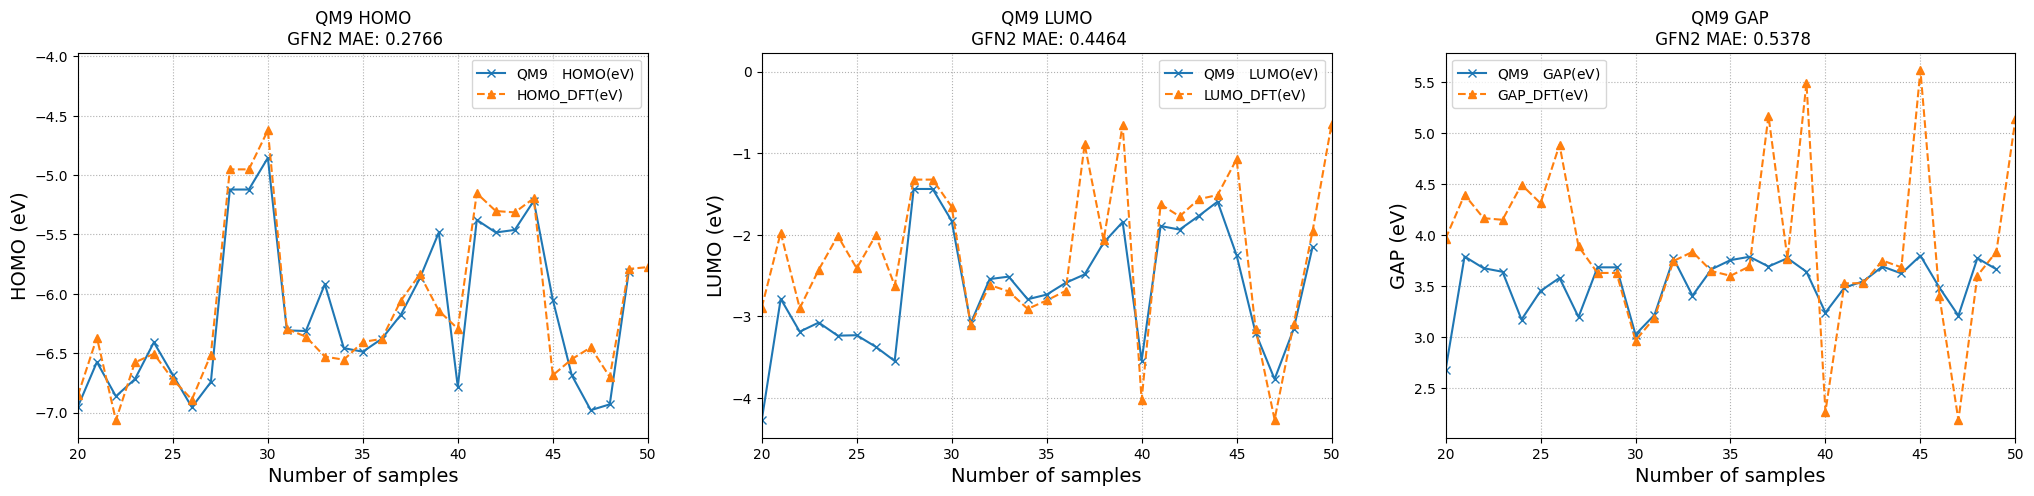

In [14]:
fig, axes = plt.subplots(1,3 , figsize=(25, 5))
actual = ['HOMO(eV)', 'LUMO(eV)', 'GAP(eV)']
lot0 = ['HOMO_DFT(eV)', 'LUMO_DFT(eV)', 'GAP_DFT(eV)']

labels = ['HOMO', 'LUMO', 'GAP']

for actual, lot0, label, ax in zip(actual, lot0, labels, axes):

    gfn0_mae = mean_absolute_error(gfn0_qm9[actual][:], gfn0_qm9[lot0][:])

    qm9_results[lot0+'-MAE'].append(gfn0_mae)
    
    ax.plot(gfn0_qm9[actual][20:50], '-x', label='QM9$\quad$'+actual)
    ax.plot(gfn0_qm9[lot0][20:70], '--^', label=lot0)
    ax.grid(linestyle=':')
    ax.set_xlim([20, len(gfn0_qm9[lot0][20:70])])

    ax.set_title(" QM9 {} \n GFN2 MAE: {:.4f}".format(label, gfn0_mae))
    
    ax.legend(loc='best')
    ax.set_xlabel('Number of samples', fontsize=14)
    ax.set_ylabel('{} (eV)'.format(label), fontsize=14)

qm9_results_df = pd.DataFrame(qm9_results)


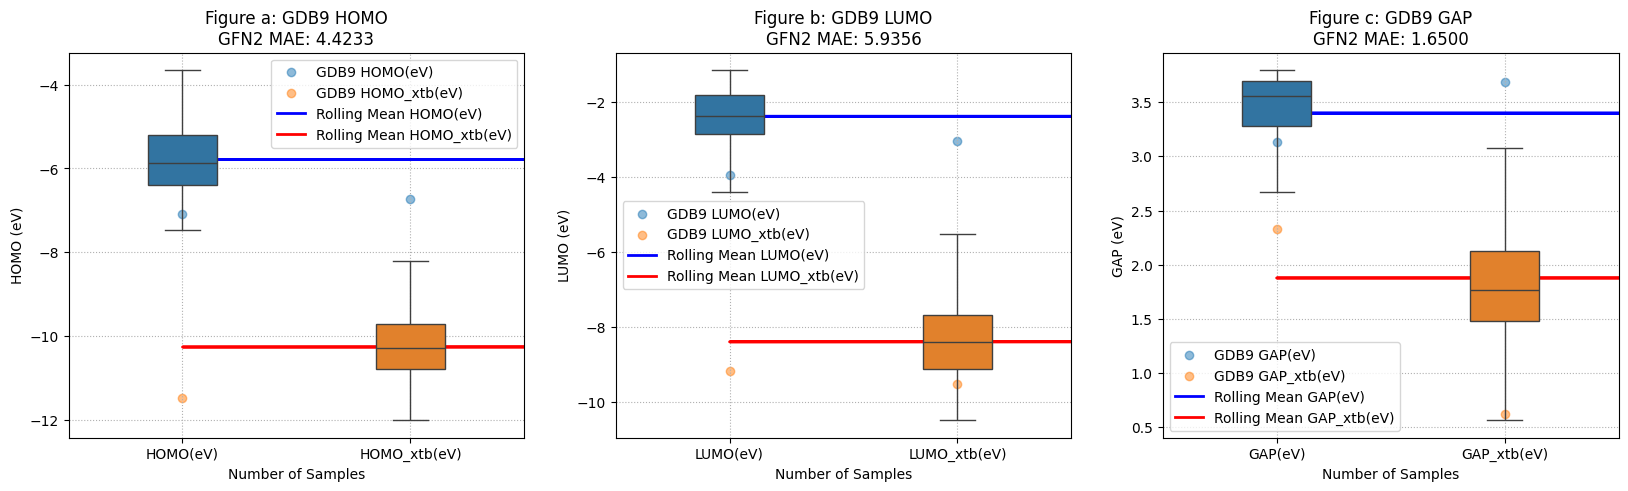

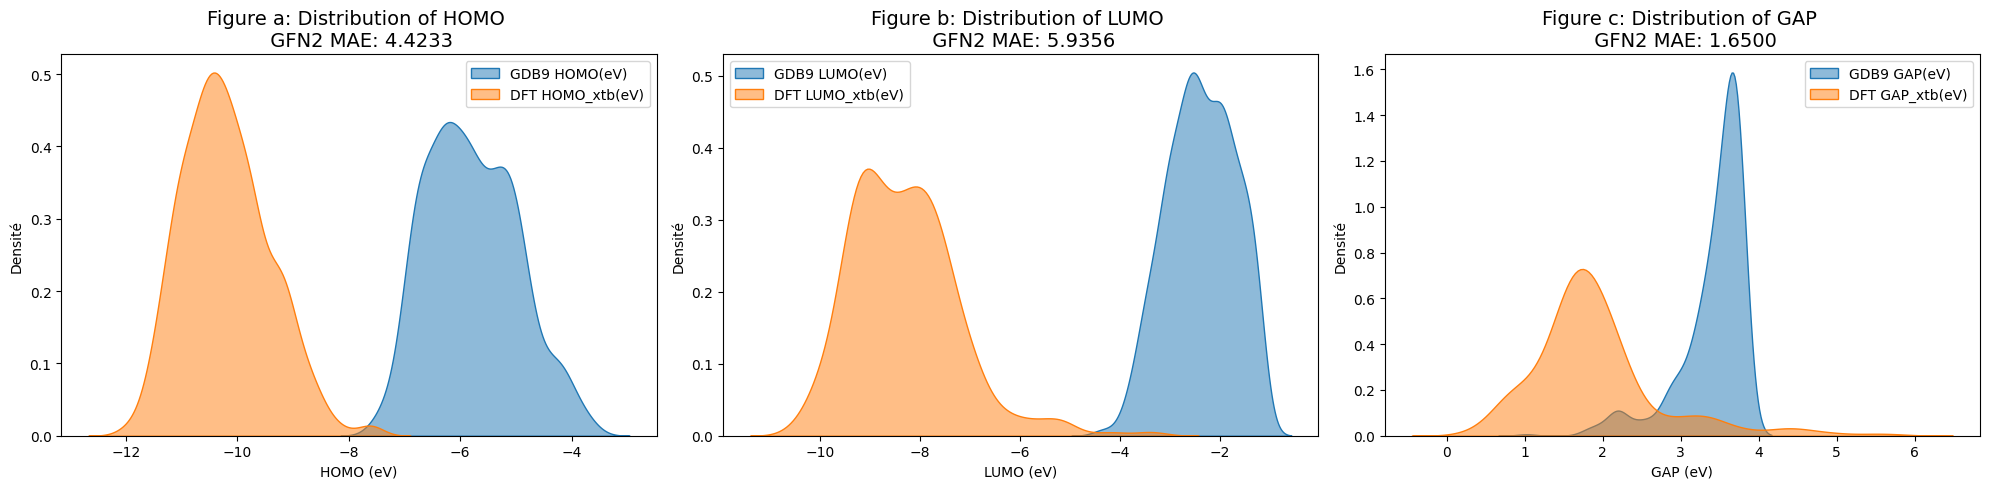

In [24]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import pandas as pd
from sklearn.metrics import mean_absolute_error
actual = ['HOMO(eV)', 'LUMO(eV)', 'GAP(eV)']
lot0 = ['HOMO_xtb(eV)', 'LUMO_xtb(eV)', 'GAP_xtb(eV)']
labels = ['HOMO', 'LUMO', 'GAP']

# Création des sous-figures pour scatter/boxplot
fig_scatter, axes_scatter = plt.subplots(1, 3, figsize=(20, 5))

# Création des sous-figures pour KDE plots
fig_kde, axes_kde = plt.subplots(1, 3, figsize=(20, 5))

# Boucle pour les deux types de visualisations
for i, (act, pred, label, ax_s, ax_k) in enumerate(zip(actual, lot0, labels, axes_scatter, axes_kde)):
    
    # Calcul du MAE
    mae = mean_absolute_error(df_sample[act], df_sample[pred])
    qm9_results[pred + '-MAE'].append(mae)

    fig_id = chr(97 + i)  # Convertit l'index en lettre (a, b, c...)

    # Scatter plot + rolling mean + boxplot
    ax_s.scatter(df_sample.index, df_sample[act], label=f'GDB9 {act}', alpha=0.5)
    ax_s.scatter(df_sample.index, df_sample[pred], label=f'GDB9 {pred}', alpha=0.5)
    df_sample['rolling_mean_actual'] = df_sample[act].rolling(50).mean()
    df_sample['rolling_mean_pred'] = df_sample[pred].rolling(50).mean()
    ax_s.plot(df_sample.index, df_sample['rolling_mean_actual'], color='blue', linewidth=2, label='Rolling Mean ' + act)
    ax_s.plot(df_sample.index, df_sample['rolling_mean_pred'], color='red', linewidth=2, label='Rolling Mean ' + pred)
    sns.boxplot(data=df_sample[[act, pred]], ax=ax_s, width=0.3, showfliers=False)
    ax_s.grid(linestyle=':')
    ax_s.set_title(f"Figure {fig_id}: GDB9 {label}\nGFN2 MAE: {mae:.4f}")
    ax_s.legend(loc='best')
    ax_s.set_xlabel('Number of Samples')
    ax_s.set_ylabel(f'{label} (eV)')

    # KDE plot
    sns.kdeplot(df_sample[act], fill=True, alpha=0.5, label=f'GDB9 {act}', ax=ax_k)
    sns.kdeplot(df_sample[pred], fill=True, alpha=0.5, label=f'DFT {pred}', ax=ax_k)
    ax_k.set_title(f"Figure {fig_id}: Distribution of {label} \n GFN2 MAE: {mae:.4f}", fontsize=14)
    ax_k.set_xlabel(f'{label} (eV)')
    ax_k.set_ylabel('Densité')
    ax_k.legend()

plt.tight_layout()

# Sauvegarde dans un PDF
with PdfPages('qm9_gfn_combined_plots.pdf') as pdf:
    pdf.savefig(fig_scatter)
    pdf.savefig(fig_kde)

plt.show()

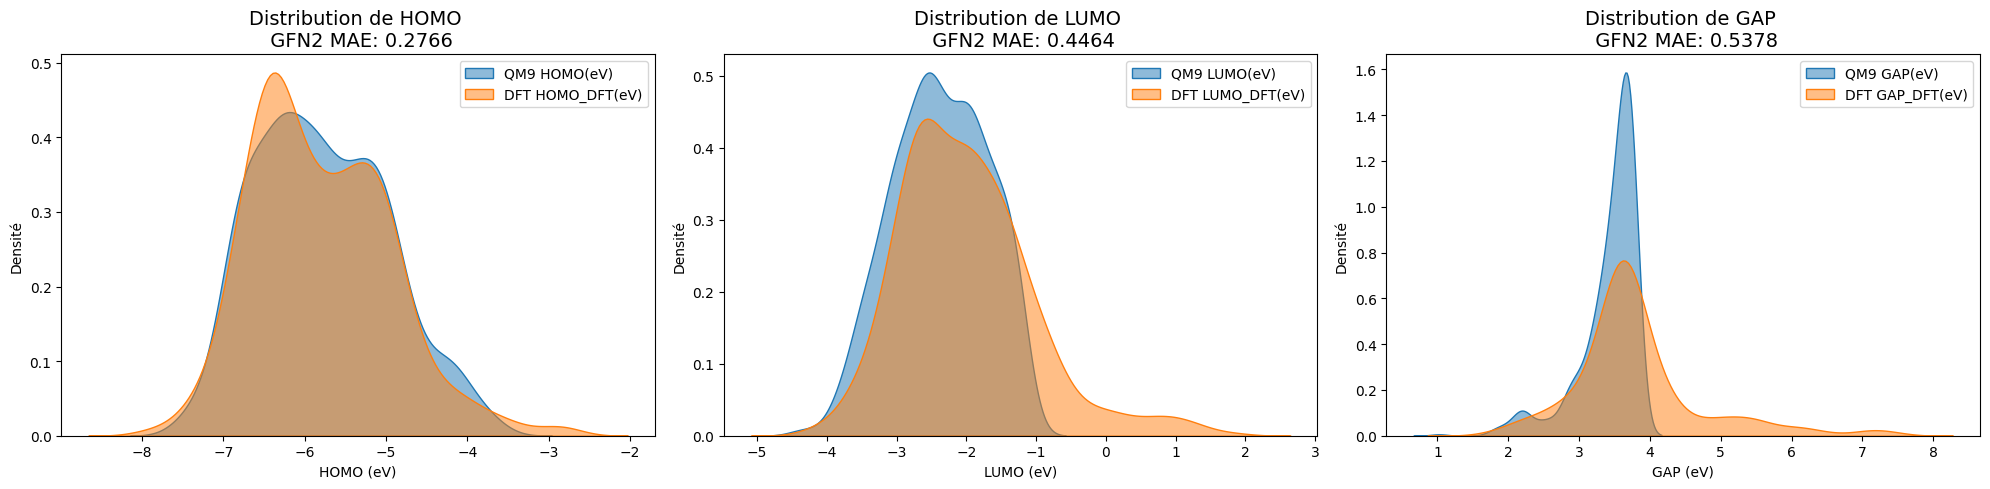

In [67]:

# Création des sous-figures pour 3 KDE plots
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Noms des colonnes pour les énergies
actual = ['HOMO(eV)', 'LUMO(eV)', 'GAP(eV)']
lot0 = ['HOMO_DFT(eV)', 'LUMO_DFT(eV)', 'GAP_DFT(eV)']
labels = ['HOMO', 'LUMO', 'GAP']

# Sous-échantillonnage pour éviter surcharge
df_sample = gfn0_qm9.sample(len(gfn0_qm9), random_state=142)

for act, pred, label, ax in zip(actual, lot0, labels, axes):
    
    # Calcul du MAE
    mae = mean_absolute_error(df_sample[act], df_sample[pred])

    # Stockage dans le dictionnaire des résultats
    qm9_results[pred + '-MAE'].append(mae)

    # 🔹 Courbes de densité (KDE)
    sns.kdeplot(df_sample[act], fill=True, alpha=0.5, label=f'QM9 {act}', ax=ax)
    sns.kdeplot(df_sample[pred], fill=True, alpha=0.5, label=f'DFT {pred}', ax=ax)

    # Mise en forme
    ax.set_title(f"Distribution de {label} \n GFN2 MAE: {mae:.4f}", fontsize=14)
    ax.set_xlabel(f'{label} (eV)')
    ax.set_ylabel('Densité')
    ax.legend()

plt.tight_layout()
plt.show()

# Conversion des résultats en DataFrame
qm9_results_df = pd.DataFrame(qm9_results)


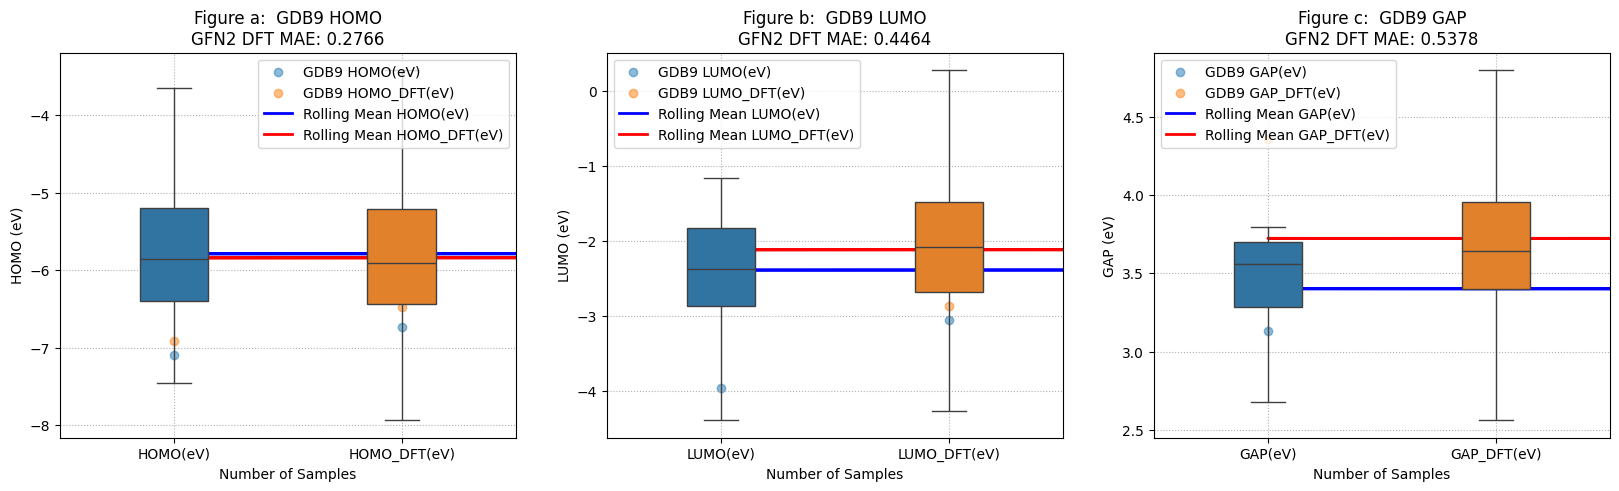

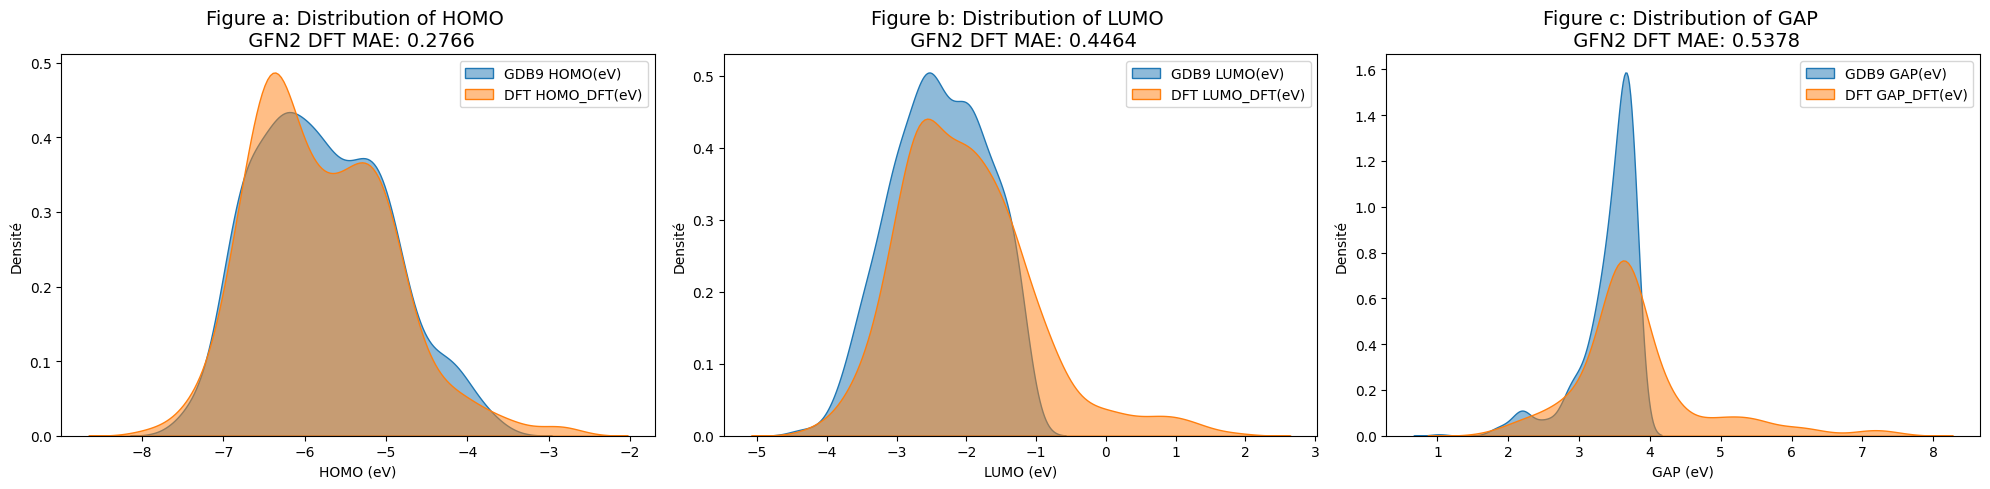

In [25]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import pandas as pd
from sklearn.metrics import mean_absolute_error

# Création des sous-figures pour scatter/boxplot
fig_scatter, axes_scatter = plt.subplots(1, 3, figsize=(20, 5))
actual = ['HOMO(eV)', 'LUMO(eV)', 'GAP(eV)']
lot0 = ['HOMO_DFT(eV)', 'LUMO_DFT(eV)', 'GAP_DFT(eV)']
labels = ['HOMO', 'LUMO', 'GAP']

# Création des sous-figures pour KDE plots
fig_kde, axes_kde = plt.subplots(1, 3, figsize=(20, 5))

# Boucle pour les deux types de visualisations
for i, (act, pred, label, ax_s, ax_k) in enumerate(zip(actual, lot0, labels, axes_scatter, axes_kde)):
    
    # Calcul du MAE
    mae = mean_absolute_error(df_sample[act], df_sample[pred])
    qm9_results[pred + '-MAE'].append(mae)

    fig_id = chr(97 + i)  # Convertit l'index en lettre (a, b, c...)

    # Scatter plot + rolling mean + boxplot
    ax_s.scatter(df_sample.index, df_sample[act], label=f'GDB9 {act}', alpha=0.5)
    ax_s.scatter(df_sample.index, df_sample[pred], label=f'GDB9 {pred}', alpha=0.5)
    df_sample['rolling_mean_actual'] = df_sample[act].rolling(50).mean()
    df_sample['rolling_mean_pred'] = df_sample[pred].rolling(50).mean()
    ax_s.plot(df_sample.index, df_sample['rolling_mean_actual'], color='blue', linewidth=2, label='Rolling Mean ' + act)
    ax_s.plot(df_sample.index, df_sample['rolling_mean_pred'], color='red', linewidth=2, label='Rolling Mean ' + pred)
    sns.boxplot(data=df_sample[[act, pred]], ax=ax_s, width=0.3, showfliers=False)
    ax_s.grid(linestyle=':')
    ax_s.set_title(f"Figure {fig_id}:  GDB9 {label}\nGFN2 DFT MAE: {mae:.4f}")
    ax_s.legend(loc='best')
    ax_s.set_xlabel('Number of Samples')
    ax_s.set_ylabel(f'{label} (eV)')

    # KDE plot
    sns.kdeplot(df_sample[act], fill=True, alpha=0.5, label=f'GDB9 {act}', ax=ax_k)
    sns.kdeplot(df_sample[pred], fill=True, alpha=0.5, label=f'DFT {pred}', ax=ax_k)
    ax_k.set_title(f"Figure {fig_id}: Distribution of {label} \n GFN2 DFT MAE: {mae:.4f}", fontsize=14)
    ax_k.set_xlabel(f'{label} (eV)')
    ax_k.set_ylabel('Densité')
    ax_k.legend()

plt.tight_layout()

# Sauvegarde dans un PDF
with PdfPages('qm9_dft_combined_plots.pdf') as pdf:
    pdf.savefig(fig_scatter)
    pdf.savefig(fig_kde)

plt.show()

# # Conversion des résultats en DataFrame
# qm9_results_df = pd.DataFrame(qm9_results)

# Résultat prêt dans un seul PDF 🎉


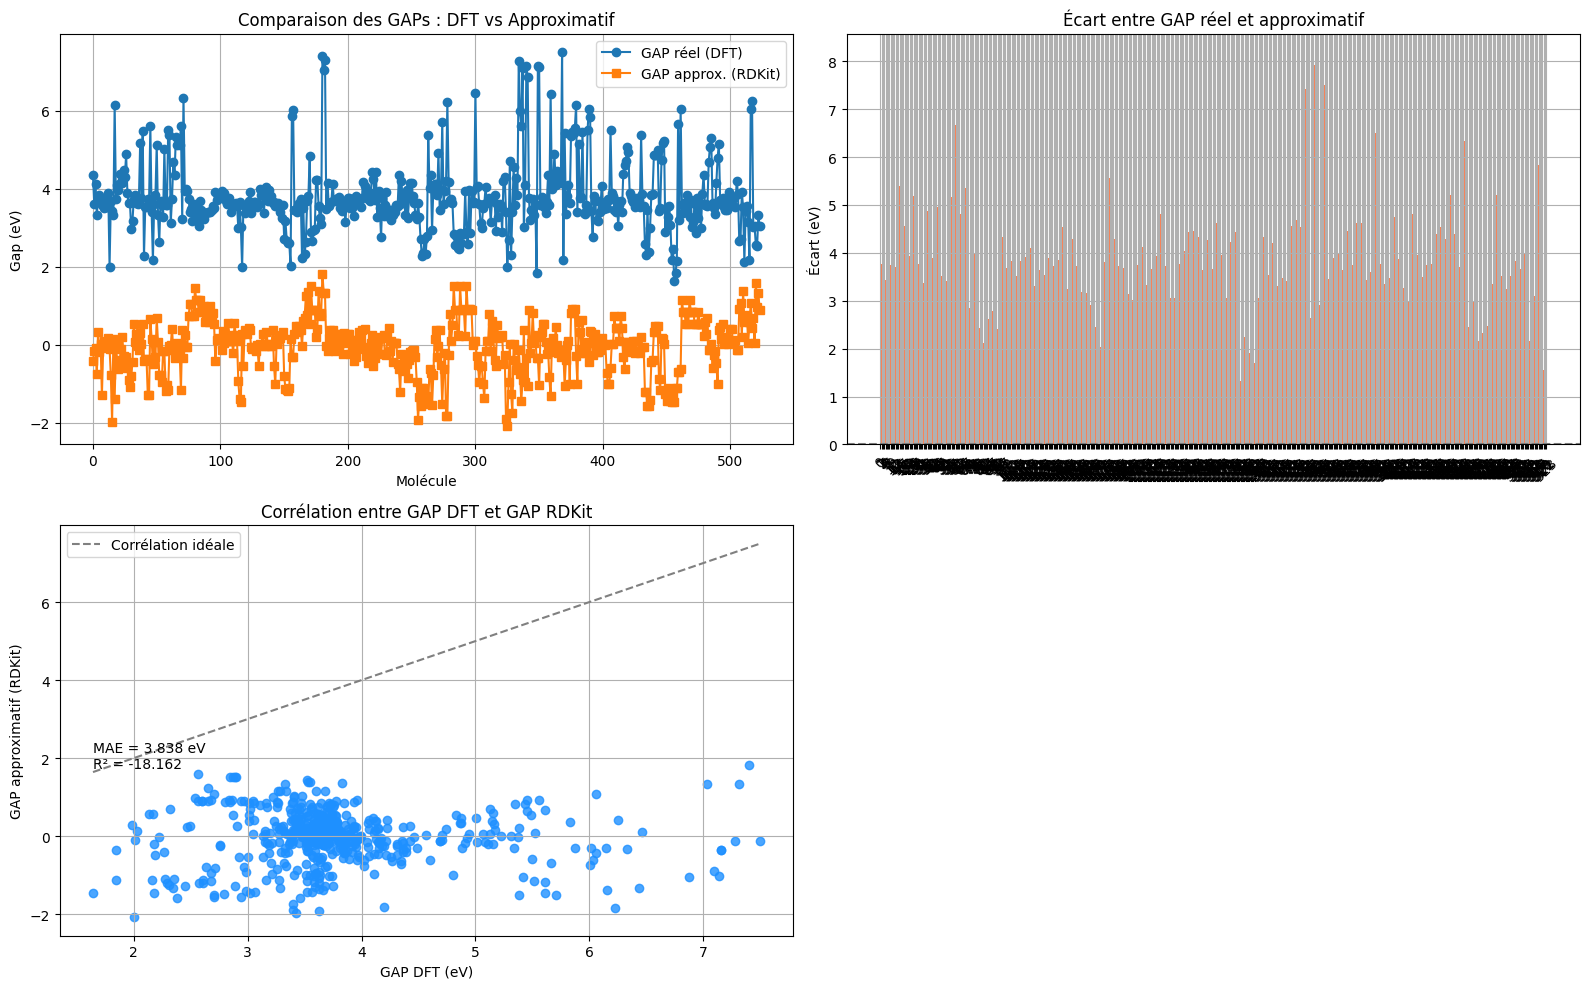

✅ Données sauvegardées dans : gap_comparison_dataset.csv
📉 MAE = 3.8376 eV | R² = -18.1616


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors
from rdkit.Chem.QED import qed
from sklearn.metrics import r2_score, mean_absolute_error

# === 1. Chargement du DataFrame contenant SMILES + GAP réel
# Exemple : df = pd.read_csv("gfn0_qm9.csv") ou déjà défini comme gfn0_qm9
df = gfn0_qm9.copy()  # Assure que df existe

# === 2. Calcul du GAP approximatif avec RDKit
approx_data = []
for _, row in df.iterrows():
    mol = Chem.MolFromSmiles(row["SMILES"])
    if mol:
        logp = Crippen.MolLogP(mol)
        fraction_csp3 = rdMolDescriptors.CalcFractionCSP3(mol)
        qed_val = qed(mol)

        gap = 0.5 * (logp + fraction_csp3 + qed_val)

        hardness = gap / 2
        mu = -gap / 2
        omega = (mu ** 2) / (2 * hardness) if hardness != 0 else np.nan

        approx_data.append({
            "Approx Gap": gap,
            "Hardness (η)": hardness,
            "Chemical Potential (μ)": mu,
            "Electrophilicity (ω)": omega
        })
    else:
        approx_data.append({
            "Approx Gap": np.nan,
            "Hardness (η)": np.nan,
            "Chemical Potential (μ)": np.nan,
            "Electrophilicity (ω)": np.nan
        })

df_approx = pd.DataFrame(approx_data)
df_full = pd.concat([df.reset_index(drop=True), df_approx], axis=1)

# === 3. Nettoyage & MAE
true_gap_col = "GAP_DFT(eV)"  # Corriger s'il y a des quotes
df_full["Gap Δ (Real - Approx)"] = df_full[true_gap_col] - df_full["Approx Gap"]

# Nettoyage des NaN
df_eval = df_full.dropna(subset=["Approx Gap", true_gap_col])
mae = mean_absolute_error(df_eval[true_gap_col], df_eval["Approx Gap"])
r2 = r2_score(df_eval[true_gap_col], df_eval["Approx Gap"])

# === 4. Visualisation comparative
plt.figure(figsize=(16, 10))

# Plot 1 : GAP réel vs approximatif
plt.subplot(2, 2, 1)
plt.plot(df_eval.index, df_eval[true_gap_col], label="GAP réel (DFT)", marker='o')
plt.plot(df_eval.index, df_eval["Approx Gap"], label="GAP approx. (RDKit)", marker='s')
plt.xlabel("Molécule")
plt.ylabel("Gap (eV)")
plt.title("Comparaison des GAPs : DFT vs Approximatif")
plt.legend()
plt.grid(True)

# Plot 2 : Δ GAP (écart)
plt.subplot(2, 2, 2)
plt.bar(df_eval.index.astype(str), df_eval["Gap Δ (Real - Approx)"], color="coral")
plt.axhline(0, linestyle="--", color="gray")
plt.ylabel("Écart (eV)")
plt.title("Écart entre GAP réel et approximatif")
plt.xticks(rotation=45)
plt.grid(True)

# Plot 3 : Corrélation
plt.subplot(2, 2, 3)
plt.scatter(df_eval[true_gap_col], df_eval["Approx Gap"], color="dodgerblue", alpha=0.8)
plt.plot([df_eval[true_gap_col].min(), df_eval[true_gap_col].max()],
         [df_eval[true_gap_col].min(), df_eval[true_gap_col].max()],
         linestyle="--", color="gray", label="Corrélation idéale")
plt.xlabel("GAP DFT (eV)")
plt.ylabel("GAP approximatif (RDKit)")
plt.title("Corrélation entre GAP DFT et GAP RDKit")
plt.text(df_eval[true_gap_col].min(), df_eval["Approx Gap"].max()*0.95,
         f"MAE = {mae:.3f} eV\nR² = {r2:.3f}", fontsize=10)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("gap_comparison_analysis.png", dpi=300)
plt.show()

# === 5. Export du dataset
df_full.to_csv("gap_comparison_dataset.csv", index=False)
print("✅ Données sauvegardées dans : gap_comparison_dataset.csv")
print(f"📉 MAE = {mae:.4f} eV | R² = {r2:.4f}")


In [8]:
df_props

,Id,SMILES,GAP_DFT(eV),Hardness (η),Chemical Potential (μ),Electrophilicity (ω),MW,LogP,TPSA,HBA,HBD,Rotatable Bonds,Aromatic Rings,Heavy Atoms,QED,FractionCSP3
0,326,O=CC(=O)C=O,4.361068,2.180534,4.732981,5.136611,86.046,-1.0467,51.21,3,0,2,0,6,0.244652,0.000000
1,723,C1=NN=CN=N1,3.603034,1.801517,4.670122,6.053242,82.066,-0.7334,51.56,4,0,0,1,6,0.413589,0.000000
2,1587,CC(=O)C(=O)C=O,4.126882,2.063441,4.580591,5.084181,100.073,-0.6566,51.21,3,0,2,0,7,0.262834,0.250000
3,1589,NC(=O)C(=O)C=O,3.333229,1.666615,5.065983,7.699497,101.061,-1.7603,77.23,3,1,2,0,7,0.254055,0.000000
4,2115,O=C1CC=CC1=O,3.773808,1.886904,4.542763,5.468402,96.085,0.0845,34.14,2,0,0,0,7,0.400179,0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519,133853,OC12C3C1N1CC3N=C21,3.044415,1.522207,4.083997,5.478568,122.127,-1.1742,35.83,3,1,0,0,9,0.439003,0.833333
520,133854,CC12CC34CC=C(C13)C24,2.562179,1.281089,3.088286,3.722422,118.179,1.9725,0.00,0,0,0,0,9,0.426493,0.777778
521,133858,CC1N2C3C4=CCC13C24,2.533469,1.266734,3.335479,4.391377,119.167,0.7714,3.24,1,0,0,0,9,0.425659,0.750000
522,133864,C1C2CC3OC4CC1C234,3.329020,1.664510,3.650386,4.002775,122.167,1.1837,9.23,1,0,0,0,9,0.468563,1.000000


In [20]:
os.makedirs("figures_xtb", exist_ok=True)


In [5]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors
from rdkit.Chem.QED import qed
from pyscf.data import nist

# Conversion Hartree → eV
au2ev = nist.HARTREE2EV

# === Chargement du DataFrame (SMILES, GAP, HOMO, LUMO, ID)
df = gfn0_qm9.copy()
df["Id"] = df["Id"].astype(str)

# === 📁 Dossier contenant les fichiers .log
log_dir = "xTB_OPT_LOG"

# === Fonction d'extraction via regex
def extract_float(pattern, text):
    match = re.search(pattern, text)
    return float(match.group(1)) if match else np.nan

# === Analyse des logs
results = []
for fname in os.listdir(log_dir):
    if fname.endswith("_xtb1_opt.log"):
        mol_id = fname.split("_")[0].replace("gdb", "").strip()
        row = df[df["Id"] == mol_id]

        if row.empty:
            print(f"⚠️ ID {mol_id} non trouvé.")
            continue

        row = row.iloc[0]
        smi = row["SMILES"]
        gap = row["GAP_DFT(eV)"]
        homo = row["HOMO_DFT(eV)"]
        lumo = row["LUMO_DFT(eV)"]
        mol = Chem.MolFromSmiles(smi)

        if not mol:
            print(f"❌ SMILES invalide : {smi}")
            continue

        # Lecture du fichier ligne par ligne
        log_path = os.path.join(log_dir, fname)
        with open(log_path, 'r') as f:
            text_content = f.readlines()
            text_full = "".join(text_content)

        # Extraction des énergies
        total_energy = extract_float(r"TOTAL ENERGY\s+(-?\d+\.\d+)\s+Eh", text_full)
        electronic_energy = extract_float(r"SCC energy\s+(-?\d+\.\d+)\s+Eh", text_full)
        nuclear_repulsion = extract_float(r"repulsion energy\s+(-?\d+\.\d+)\s+Eh", text_full)
        solvation_energy = extract_float(r"Gsolv\s+(-?\d+\.\d+)\s+Eh", text_full)

        # ✅ Dipôle : bloc après 'molecular dipole:'
        mol_dipole_val = np.nan
        mol_dipole = [text_content[i:i+4] for i, line in enumerate(text_content) if 'molecular dipole:' in line]
        if mol_dipole:
            try:
                last_line = mol_dipole[0][-1]  # ligne contenant "full: ... tot"
                mol_dipole_val = float(last_line.strip().split()[-1])
            except Exception:
                pass

        # === Propriétés dérivées
        hardness = gap / 2 if not np.isnan(gap) else np.nan
        mu = -(homo + lumo) / 2 if not (np.isnan(homo) or np.isnan(lumo)) else np.nan
        omega = (mu ** 2) / (2 * hardness) if hardness and hardness != 0 else np.nan

        results.append({
            "Id": mol_id,
            "Log File": fname,
            "SMILES": smi,
            "GAP_DFT(eV)": gap,
            "HOMO_DFT(eV)": homo,
            "LUMO_DFT(eV)": lumo,
            "Total Energy (eV)": total_energy * au2ev if total_energy else np.nan,
            "Electronic Energy (eV)": electronic_energy * au2ev if electronic_energy else np.nan,
            "Nuclear Repulsion Energy (eV)": nuclear_repulsion * au2ev if nuclear_repulsion else np.nan,
            "Gsolv (eV)": solvation_energy * au2ev if solvation_energy else np.nan,
            "Dipole (D)": mol_dipole_val,
            "Hardness η (eV)": hardness,
            "Chemical Potential μ (eV)": mu,
            "Electrophilicity ω (eV)": omega,
            "MW": Descriptors.MolWt(mol),
            "LogP": Crippen.MolLogP(mol),
            "TPSA": rdMolDescriptors.CalcTPSA(mol),
            "HBA": Descriptors.NumHAcceptors(mol),
            "HBD": Descriptors.NumHDonors(mol),
            "Rotatable Bonds": Descriptors.NumRotatableBonds(mol),
            "Aromatic Rings": Descriptors.NumAromaticRings(mol),
            "Heavy Atoms": Descriptors.HeavyAtomCount(mol),
            "QED": qed(mol),
            "FractionCSP3": rdMolDescriptors.CalcFractionCSP3(mol)
        })

# === 🧾 DataFrame des résultats
df_xtb_all = pd.DataFrame(results).sort_values("Id").reset_index(drop=True)

# === 💾 Sauvegarde
df_xtb_all.to_csv("xtb_all_quantum_properties.csv", index=False)
df_xtb_all.to_pickle("xtb_all_quantum_properties.pkl")
print("✅ Données enregistrées dans xtb_all_quantum_properties.csv et .pkl")


✅ Données enregistrées dans xtb_all_quantum_properties.csv et .pkl


In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Chargement des résultats
df_xtb_all = pd.read_csv("xtb_all_quantum_properties.csv")

# Créer un dossier pour les figures
os.makedirs("figures_xtb", exist_ok=True)

# Colonnes numériques uniquement
numeric_cols = df_xtb_all.select_dtypes(include=[np.number]).columns.tolist()

# Références critiques (avec direction de stabilité)
reference_lines = {
    "GAP_DFT(eV)": (3.8, "high"),        # Si gap < 4.5 → instable
    "Hardness η (eV)": (2.2, "low"),     # Si η < 2.2 → instable
    "Chemical Potential μ (eV)": (-4.0, "high"),  # Si μ > -4.0 → instable
    "Electrophilicity ω (eV)": (1.5, "high"),     # Si ω > 1.5 → trop électrophile
    "Dipole (D)": (2.0, "high"),         # Trop polaire = instable dans certains cas
}

# Tracé automatisé
for col in numeric_cols:
    data = df_xtb_all[col].dropna()

    if data.nunique() < 5 or data.max() == data.min():
        continue

    plt.figure(figsize=(8, 5))
    sns.histplot(data, bins=40, kde=True, color='royalblue', edgecolor='black', linewidth=1.2)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.title(f"Distribution of {col}", fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Frequency", fontsize=12)

    mean = data.mean()
    std = data.std()

    plt.axvline(mean, color='red', linestyle='--', label=f"Mean: {mean:.2f}")
    plt.axvline(mean + std, color='orange', linestyle=':', label=f"+1σ: {mean + std:.2f}")
    plt.axvline(mean - std, color='orange', linestyle=':', label=f"-1σ: {mean - std:.2f}")

    if col in reference_lines:
        ref_val, direction = reference_lines[col]
        plt.axvline(ref_val, color='green', linestyle='-.', label=f"Critère: {ref_val}")

        # Zone hachurée instable
        if direction == "low":
            plt.axvspan(data.min(), ref_val, color='lightgrey', alpha=0.4, label='Zone instable')
        elif direction == "high":
            plt.axvspan(ref_val, data.max(), color='lightgrey', alpha=0.4, label='Zone instable')

    plt.legend()
    plt.tight_layout()
    filename = col.replace(" ", "_").replace("(", "").replace(")", "").replace("η", "eta").replace("μ", "mu").replace("ω", "omega")
    plt.savefig(f"figures_xtb/{filename}_stability_distribution.png", dpi=300)
    plt.close()

print("✅ Graphiques de stabilité sauvegardés dans `figures_xtb/`.")



✅ Graphiques de stabilité sauvegardés dans `figures_xtb/`.


In [6]:
a=df_xtb_all.iloc[: ,4:]
a

,HOMO_DFT(eV),LUMO_DFT(eV),Total Energy (eV),Electronic Energy (eV),Nuclear Repulsion Energy (eV),Gsolv (eV),Dipole (D),Hardness η (eV),Chemical Potential μ (eV),Electrophilicity ω (eV),MW,LogP,TPSA,HBA,HBD,Rotatable Bonds,Aromatic Rings,Heavy Atoms,QED,FractionCSP3
0,-6.215297,1.066124,-831.459509,-840.814534,9.365805,-0.478484,8.352,3.640710,2.574586,0.910330,131.175,-1.60550,67.77,2,1,3,0,9,0.500643,0.833333
1,-4.951548,-1.324778,-603.869061,-614.985365,11.118547,-0.721806,12.700,1.813385,3.138163,2.715382,108.104,-2.36685,87.57,2,2,1,0,8,0.223450,0.000000
2,-6.842676,-0.835324,-773.609354,-784.373123,10.764444,-0.439627,8.109,3.003676,3.839000,2.453314,127.143,-2.38230,67.77,2,1,1,0,9,0.399481,0.500000
3,-6.773616,-1.164358,-797.793543,-807.368156,9.575440,-0.416122,5.848,2.804629,3.968987,2.808367,129.115,-3.65750,88.00,3,2,1,0,9,0.357589,0.400000
4,-6.292383,0.804250,-855.626399,-863.775691,8.175235,-0.478003,8.477,3.548317,2.744067,1.061053,133.147,-3.02480,88.00,3,2,3,0,9,0.429103,0.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519,-6.399088,-1.833516,-781.605692,-790.772949,9.169081,-0.425827,5.375,2.282786,4.116302,3.711242,128.131,-0.65883,70.02,3,2,2,0,9,0.294474,0.400000
520,-5.876021,-2.286324,-771.770451,-781.253416,9.483921,-0.421276,6.118,1.794849,4.081172,4.639936,128.135,-1.31186,102.82,3,4,2,0,9,0.273934,0.250000
521,-6.555140,-2.287787,-789.503464,-798.333836,8.832028,-0.508313,7.576,2.133676,4.421464,4.581140,129.119,-1.76253,96.04,3,3,2,0,9,0.233851,0.250000
522,-6.344399,-2.503297,-789.681137,-798.542641,8.862965,-0.382113,2.860,1.920551,4.423848,5.095003,129.119,-1.54433,82.05,3,3,1,0,9,0.173469,0.250000


In [7]:
df_xtb_all

,Id,Log File,SMILES,GAP_DFT(eV),HOMO_DFT(eV),LUMO_DFT(eV),Total Energy (eV),Electronic Energy (eV),Nuclear Repulsion Energy (eV),Gsolv (eV),...,MW,LogP,TPSA,HBA,HBD,Rotatable Bonds,Aromatic Rings,Heavy Atoms,QED,FractionCSP3
0,100076,gdb 100076_xtb1_opt.log,CC(C)(C[NH3+])CC([O-])=O,7.281420,-6.215297,1.066124,-831.459509,-840.814534,9.365805,-0.478484,...,131.175,-1.60550,67.77,2,1,3,0,9,0.500643,0.833333
1,10016,gdb 10016_xtb1_opt.log,NC=[NH+][C-](C#N)C#N,3.626770,-4.951548,-1.324778,-603.869061,-614.985365,11.118547,-0.721806,...,108.104,-2.36685,87.57,2,2,1,0,8,0.223450,0.000000
2,100443,gdb 100443_xtb1_opt.log,CC(C[NH3+])C#CC([O-])=O,6.007352,-6.842676,-0.835324,-773.609354,-784.373123,10.764444,-0.439627,...,127.143,-2.38230,67.77,2,1,1,0,9,0.399481,0.500000
3,100457,gdb 100457_xtb1_opt.log,[NH3+]CC(O)C#CC([O-])=O,5.609259,-6.773616,-1.164358,-797.793543,-807.368156,9.575440,-0.416122,...,129.115,-3.65750,88.00,3,2,1,0,9,0.357589,0.400000
4,100710,gdb 100710_xtb1_opt.log,CC(C[NH3+])C(O)C([O-])=O,7.096633,-6.292383,0.804250,-855.626399,-863.775691,8.175235,-0.478003,...,133.147,-3.02480,88.00,3,2,3,0,9,0.429103,0.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519,98058,gdb 98058_xtb1_opt.log,CNC(=N)C(=O)C(C)=O,4.565572,-6.399088,-1.833516,-781.605692,-790.772949,9.169081,-0.425827,...,128.131,-0.65883,70.02,3,2,2,0,9,0.294474,0.400000
520,98059,gdb 98059_xtb1_opt.log,CNC(=N)C(=O)C(N)=N,3.589697,-5.876021,-2.286324,-771.770451,-781.253416,9.483921,-0.421276,...,128.135,-1.31186,102.82,3,4,2,0,9,0.273934,0.250000
521,98060,gdb 98060_xtb1_opt.log,CNC(=N)C(=O)C(N)=O,4.267353,-6.555140,-2.287787,-789.503464,-798.333836,8.832028,-0.508313,...,129.119,-1.76253,96.04,3,3,2,0,9,0.233851,0.250000
522,98956,gdb 98956_xtb1_opt.log,CNC(=N)NC(=O)C=O,3.841103,-6.344399,-2.503297,-789.681137,-798.542641,8.862965,-0.382113,...,129.119,-1.54433,82.05,3,3,1,0,9,0.173469,0.250000


In [6]:
qm9_results_df

,HOMO_DFT(eV)-MAE,LUMO_DFT(eV)-MAE,GAP_DFT(eV)-MAE
15 Random QM9 Samples,0.276557,0.446448,0.537806


* **Total Energy (KCal/mol) Visualization**

In [10]:
orca1_qm9 = pd.read_csv('energies.csv')
orca1_qm9

,mol_id,HOMO_ORCA(eV),LUMO_ORCA(eV),GAP_ORCA(eV)
0,gdb53892,-5.0275,-1.4531,3.5744
1,gdb24766,-5.9361,-2.5160,3.4201
2,gdb23724,-5.5355,-1.5868,3.9487
3,gdb47276,-6.6466,-2.9472,3.6994
4,gdb29054,-5.7971,-1.9867,3.8104
...,...,...,...,...
519,gdb130366,-4.5154,-1.4430,3.0724
520,gdb130511,-5.5275,-2.2325,3.2950
521,gdb129337,-4.1838,-1.9567,2.2271
522,gdb24846,-6.5395,-2.6295,3.9100


In [20]:
import pandas as pd

# Exemple de DataFrame 1 (avec mol_id en désordre)

# Étape 1 : Extraire la partie numérique de mol_id et la convertir en entier
orca1_qm9['mol_id'] = orca1_qm9['mol_id'].str.extract('(\d+)').astype(int)

# Étape 2 : Trier df1 par mol_id
df1_sorted = orca1_qm9.sort_values(by='mol_id').reset_index(drop=True)

# Étape 3 : Trier df2 par Id
df2_sorted = gfn0_qm9.sort_values(by='Id').reset_index(drop=True)

# Étape 4 : Fusionner les DataFrames triés
df_merged = pd.merge(df1_sorted, df2_sorted, left_on='mol_id', right_on='Id', how='inner')

# Afficher le résultat
print(df_merged)

     mol_id  HOMO_ORCA(eV)  LUMO_ORCA(eV)  GAP_ORCA(eV)  smiles_key  \
0       326        -6.8208        -2.4523        4.3685     gdb 326   
1       723        -6.4001        -2.8171        3.5830     gdb 723   
2      1587        -6.5516        -2.4277        4.1239    gdb 1587   
3      1589        -6.6492        -3.3001        3.3491    gdb 1589   
4      2115        -6.3461        -2.5458        3.8003    gdb 2115   
..      ...            ...            ...           ...         ...   
519  133853        -5.4987        -2.4677        3.0310  gdb 133853   
520  133854        -4.2529        -1.6746        2.5783  gdb 133854   
521  133858        -4.4999        -1.9503        2.5496  gdb 133858   
522  133864        -5.1155        -1.8525        3.2630  gdb 133864   
523  133866        -4.0008        -1.1021        2.8987  gdb 133866   

                   SMILES  HOMO(eV)  HOMO_xtb(eV)  HOMO_DFT(eV)  LUMO(eV)  \
0             O=CC(=O)C=O -7.091287      -11.4928     -6.913515 -3.959

In [21]:
df_merged 

,mol_id,HOMO_ORCA(eV),LUMO_ORCA(eV),GAP_ORCA(eV),smiles_key,SMILES,HOMO(eV),HOMO_xtb(eV),HOMO_DFT(eV),LUMO(eV),LUMO_xtb(eV),LUMO_DFT(eV),GAP(eV),GAP_xtb(eV),GAP_DFT(eV),Id
0,326,-6.8208,-2.4523,4.3685,gdb 326,O=CC(=O)C=O,-7.091287,-11.4928,-6.913515,-3.959257,-9.1664,-2.552447,3.132031,2.326330,4.361068,326
1,723,-6.4001,-2.8171,3.5830,gdb 723,C1=NN=CN=N1,-6.734818,-10.1217,-6.471639,-3.050396,-9.5066,-2.868605,3.687143,0.615100,3.603034,723
2,1587,-6.5516,-2.4277,4.1239,gdb 1587,CC(=O)C(=O)C=O,-6.772914,-11.2156,-6.644032,-3.126588,-9.1516,-2.517150,3.646326,2.064026,4.126882,1587
3,1589,-6.6492,-3.3001,3.3491,gdb 1589,NC(=O)C(=O)C=O,-6.753866,-11.1089,-6.732598,-3.311626,-9.9451,-3.399369,3.442240,1.163798,3.333229,1589
4,2115,-6.3461,-2.5458,3.8003,gdb 2115,O=C1CC=CC1=O,-6.386512,-10.8568,-6.429667,-2.587803,-9.2243,-2.655859,3.798709,1.632489,3.773808,2115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519,133853,-5.4987,-2.4677,3.0310,gdb 133853,OC12C3C1N1CC3N=C21,-5.679016,-9.9375,-5.606204,-2.419092,-8.7319,-2.561790,3.259924,1.205589,3.044415,133853
520,133854,-4.2529,-1.6746,2.5783,gdb 133854,CC12CC34CC=C(C13)C24,-4.285793,-8.4207,-4.369375,-2.481678,-7.7140,-1.807196,1.804115,0.706681,2.562179,133854
521,133858,-4.4999,-1.9503,2.5496,gdb 133858,CC1N2C3C4=CCC13C24,-4.606888,-8.6748,-4.602213,-2.832705,-7.9451,-2.068744,1.774182,0.729718,2.533469,133858
522,133864,-5.1155,-1.8525,3.2630,gdb 133864,C1C2CC3OC4CC1C234,-3.771498,-9.9408,-5.314896,-1.736086,-8.5677,-1.985876,2.032691,1.373099,3.329020,133864


In [30]:
df1_sorted.to_pickle("ORCA_GDB9.pkl")

In [31]:
df_merged.to_pickle("ALL_ENERGY_ORCA_XTB_DFT_GDB9.pkl")

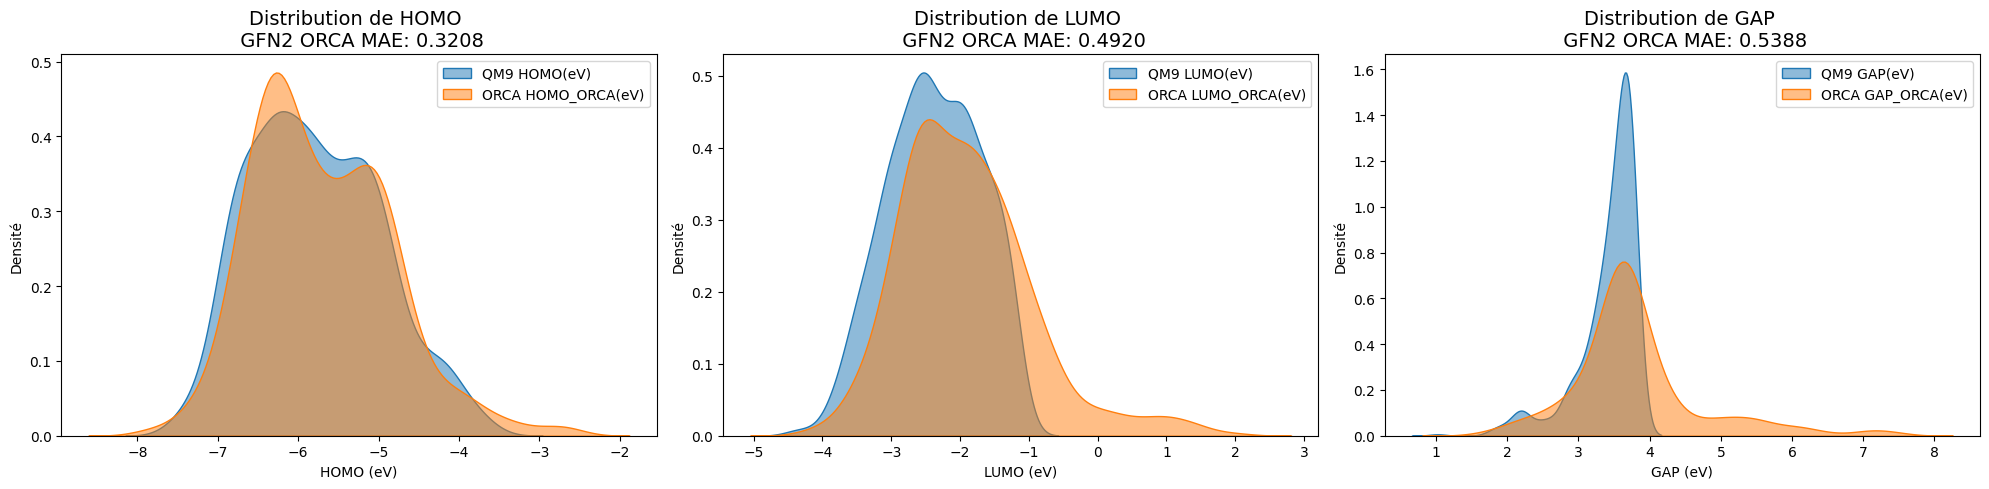

In [25]:

# Création des sous-figures pour 3 KDE plots
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Noms des colonnes pour les énergies
actual = ['HOMO(eV)', 'LUMO(eV)', 'GAP(eV)']
lot0 = ['HOMO_ORCA(eV)', 'LUMO_ORCA(eV)', 'GAP_ORCA(eV)']
labels = ['HOMO', 'LUMO', 'GAP']

# Sous-échantillonnage pour éviter surcharge
df_sample = df_merged.sample(len(df_merged), random_state=142)

for act, pred, label, ax in zip(actual, lot0, labels, axes):
    
    # Calcul du MAE
    mae = mean_absolute_error(df_sample[act], df_sample[pred])

    # Stockage dans le dictionnaire des résultats
    qm9_results[pred + '-MAE'].append(mae)

    # 🔹 Courbes de densité (KDE)
    sns.kdeplot(df_sample[act], fill=True, alpha=0.5, label=f'QM9 {act}', ax=ax)
    sns.kdeplot(df_sample[pred], fill=True, alpha=0.5, label=f'ORCA {pred}', ax=ax)

    # Mise en forme
    ax.set_title(f"Distribution de {label} \n GFN2 ORCA MAE: {mae:.4f}", fontsize=14)
    ax.set_xlabel(f'{label} (eV)')
    ax.set_ylabel('Densité')
    ax.legend()

plt.tight_layout()
plt.show()

# Conversion des résultats en DataFrame
qm9_results_df = pd.DataFrame(qm9_results)

In [3]:
import os
import subprocess as sp

# Chemin du répertoire contenant les fichiers .xyz
input_directory = "xTB_OPT1_XYZ"
# Chemin de sortie pour stocker les fichiers SDF convertis
output_directory = "xTB_OPT1_SDF"

# Créez le répertoire de sortie s'il n'existe pas
os.makedirs(output_directory, exist_ok=True)

# Parcourir tous les fichiers dans le répertoire d'entrée
for filename in os.listdir(input_directory):
    # Vérifiez si le fichier a l'extension .xyz
    if filename.endswith(".xyz"):
        # Chemin complet du fichier .xyz
        input_file_path = os.path.join(input_directory, filename)

        # Créez le nom du fichier de sortie .sdf
        output_file_name = os.path.splitext(filename)[0] + ".sdf"
        output_file_path = os.path.join(output_directory, output_file_name)

        # Vérifiez si le fichier de sortie existe déjà pour éviter des conversions inutiles
        if not os.path.exists(output_file_path):
            try:
                # Exécuter la commande obabel pour convertir de .xyz en .sdf
                sp.run(['obabel', input_file_path, '-O', output_file_path], stdout=sp.DEVNULL, stderr=sp.DEVNULL)
                print(f"Converted: {filename} -> {output_file_name}")
            except Exception as e:
                print(f"Error converting {filename}: {e}")
        else:
            print(f"File {output_file_name} already exists. Skipping.")

Converted: gdb 75416_crest1_opt.xyz -> gdb 75416_crest1_opt.sdf
Converted: gdb 103798_crest1_opt.xyz -> gdb 103798_crest1_opt.sdf
Converted: gdb 24768_crest1_opt.xyz -> gdb 24768_crest1_opt.sdf
Converted: gdb 24550_crest1_opt.xyz -> gdb 24550_crest1_opt.sdf
Converted: gdb 21134_crest1_opt.xyz -> gdb 21134_crest1_opt.sdf
Converted: gdb 24846_crest1_opt.xyz -> gdb 24846_crest1_opt.sdf
Converted: gdb 25531_crest1_opt.xyz -> gdb 25531_crest1_opt.sdf
Converted: gdb 22441_crest1_opt.xyz -> gdb 22441_crest1_opt.sdf
Converted: gdb 24535_crest1_opt.xyz -> gdb 24535_crest1_opt.sdf
Converted: gdb 22230_crest1_opt.xyz -> gdb 22230_crest1_opt.sdf
Converted: gdb 43276_crest1_opt.xyz -> gdb 43276_crest1_opt.sdf
Converted: gdb 88938_crest1_opt.xyz -> gdb 88938_crest1_opt.sdf
Converted: gdb 71536_crest1_opt.xyz -> gdb 71536_crest1_opt.sdf
Converted: gdb 60780_crest1_opt.xyz -> gdb 60780_crest1_opt.sdf
Converted: gdb 8793_crest1_opt.xyz -> gdb 8793_crest1_opt.sdf
Converted: gdb 24763_crest1_opt.xyz -> g

## **Processing Feature: Computation Time**

## **Analyzis**

|Criteria|Observation|
|:--------|-----------|
|QC Results-Energy levels|The `xTB`-`crest`-integrating QC calculations appear to be reliable methodologies for molecular simulation, as they all present quite similar energy values (HOMO, LUMO and Gap in $(eV)$) to those of the QM9 results using `Corina`-`PM7`-`B3LYP` for generating Cartesian coordinates. In consideration of the absolute errors documented above for evaluating the discrepancy between these methodologies, the comprehensive `GFN-xTB` optimization ranking is as follows: *(i)* `GFN0`, *(ii)* `GFN2`, *(iii)* `GFN1` for HOMO&LUMO energy levels and HOMO-LUMO gap.|
|QC Results-Total Energy|The molecular total energies in $(KCal/mol)$ of each sample demonstrate that `xTB`-`crest`-integrating QC calculations at all `GFNn` levels of theory $(n = 0, 1, 2)$ are converging to the same final energy state|
|CPU Time|In consideration of the CPU times reported per molecule and illustrated in section **2.4**, `GFN2` exhibits superior computational efficiency in comparison to the other `GFNn` levels of theory, followed by `GFN1` and `GFN0`. Computations were performed using a quad-core Lenovo ThinkPad X270 W10DG machine with $2.60GHz$ Intel $i7-6600U$ CPUs and 16.0GB of memory. <div class="alert alert-warning">To ensure that the computation time measured above is primarily attributed to the molecular simulation, it is essential to isolate the process on our local computer by: <ol> <li>Close any unnecessary applications, browser tabs, or background processes running on the computer</li> <li>Avoid running the process simultaneously with other resource-intensive tasks</li> </ol> Moreover, it is recommended to run the simulation process multiple times and take the average computation time.</div>|


---
# **Quick Overview On Processing And Structural Details Of Each `GFN` Level Of Theory At Each Stage Of Our Flow Chart**

For further investigations, we utilized two subsets (`cep` and `hce`) of the Clean Energy Project (CEP) which is a reference database for organic semiconductors, with a specific focus on photovoltaic applications <cite id="0q0ga"><a href="#zotero%7C9235801%2FSMKLYZLC">[3]</a></cite>.

## **Working With `cep` Dataset**

### **Data Loading**

In [7]:

gfn2_cep_path = Path(main_dir) / 'PAPER WORK/MVOTO_OPV_energy_new'

### **Processing `cep` SMILES**

* **GFN0 `xTB` level of theory**

* **GFN1 `xTB` level of theory**

In [8]:
#Optimized_DFT(data=df, working_dir=main_dir, level_of_theory=1) 

* **GFN2 `xTB` level of theory**

### **Quantum Chemistry Results**

* **Total Energy (KCal/mol) Visualization**

* **`RMSD`(Angstrom) Visualization**

In [10]:
def Mol_Dynamic(mol_path1=None, mol_path2=None, format=None, dataset=None, Id=None, level_of_theory=None, step=None):

    # load the pymol molecular objects
    mol1 = cmd.load(mol_path1, object='mol1', format=format, atom_props ='*')  
    mol2 = cmd.load(mol_path2, object='mol2', format=format, atom_props ='*')

    # Set the bond width for the other objects
    cmd.set_bond('stick_transparency', 0.55, 'mol1')

    # Set the conventional atomic colors for mol1
    cmd.color('gray', 'mol1 and elem C')
    cmd.color('white', 'mol1 and elem H')
    cmd.color('blue', 'mol1 and elem N')
    cmd.color('red', 'mol1 and elem O')
    cmd.color('yellow', 'mol1 and elem S')
    cmd.color('black', 'mol1 and elem Si')
    cmd.color('silver', 'mol1 and elem Se')

    # Set the conventional atomic colors for mol2
    cmd.color('gray', 'mol2 and elem C')
    cmd.color('white', 'mol2 and elem H')
    cmd.color('blue', 'mol2 and elem N')
    cmd.color('red', 'mol2 and elem O')
    cmd.color('yellow', 'mol2 and elem S')
    cmd.color('black', 'mol2 and elem Si')
    cmd.color('silver', 'mol2 and elem Se')

    # Align the molecules
    cmd.align("mol1", "mol2")

    # get the rmsd between the two structures
    rmsd = cmd.align('mol1', 'mol2')[0]
    
    # adjust the view
    cmd.orient()
    cmd.zoom()
    cmd.show('sticks', 'mol1')
    cmd.show('sticks', 'mol2')
    cmd.viewport(500, 500)
    #cmd.ipython_image()

    #img_path = Path(main_dir) / 'images/{}_images/sample{}'.format(step, Id)
    #if os.path.exists(img_path):
        #os.chdir(img_path.name)
    #else:
        #os.mkdir(Path(main_dir) / 'images/{}_images/sample{}'.format(step, Id))
        #img_path = Path(main_dir) / 'images/{}_images/sample{}'.format(step, Id)
        #os.chdir(img_path.name)
        
    
    cmd.png('./images/{}_{}_gfn{}_{}_deviation.png'.format(dataset, Id, level_of_theory, step), ray=1)
    visualize = Image(filename='./images/{}_{}_gfn{}_{}_deviation.png'.format(dataset, Id, level_of_theory, step))

    # Clear the PyMOL command memory
    cmd.reinitialize()

    os.chdir(main_dir)

    return rmsd, visualize

In [11]:
cep_struc_devs  = defaultdict(list)

In [12]:
import os
gfn2_cep=gfn0_qm9
# ==============================================================================
# 1. Chargement des fichiers SDF
# ==============================================================================

# Définition des chemins des différents répertoires
gfn2_path = 'GDB9_SDF_DATA'
gfn2_initial_path = 'GDB9_SDF'
gfn2_preoptimized_path = 'xTB_PRE_OPT_SDF'
gfn2_conformer_path = 'CREST_SDF'
gfn2_optimized_path = 'xTB_OPT_SDF'

# Fonction pour extraire les parties numériques des noms de fichiers pour le tri
def extract_numeric(file_name):
    return int(''.join(filter(str.isdigit, file_name)))

# Chargement et tri des fichiers dans chaque répertoire
gfn2_files = [f for f in os.listdir(gfn2_path) if f.endswith('.sdf')]
gfn2_files.sort(key=extract_numeric)

gfn2_initial_files = [f for f in os.listdir(gfn2_initial_path) if f.endswith('.sdf')]
gfn2_initial_files.sort(key=extract_numeric)

gfn2_preoptimized_files = [f for f in os.listdir(gfn2_preoptimized_path) if f.endswith('.sdf')]
gfn2_preoptimized_files.sort(key=extract_numeric)

gfn2_conformer_files = [f for f in os.listdir(gfn2_conformer_path) if f.endswith('.sdf')]
gfn2_conformer_files.sort(key=extract_numeric)

gfn2_optimized_files = [f for f in os.listdir(gfn2_optimized_path) if f.endswith('.sdf')]
gfn2_optimized_files.sort(key=extract_numeric)

# ==============================================================================
# 2. Parcours des fichiers SDF et calcul des RMSD
# ==============================================================================

# Initialisation des résultats
cep_struc_devs = {
    'Initial RMSD': [],
    'Preoptimization RMSD': [],
    'Conformation RMSD': [],
    'Final Optimization RMSD': []
}

# Exemple de dataframe contenant les IDs des molécules (gfn2_cep doit être défini au préalable)
# gfn2_cep = pd.read_csv("gfn2_cep_data.csv")

# Étape 1 : RMSD pour les fichiers initiaux
for i, (input_file, output_file) in enumerate(zip(gfn2_files, gfn2_initial_files)):
    input_path0 = os.path.join(gfn2_path, input_file)
    output_path0 = os.path.join(gfn2_initial_path, output_file)
    
    Id = gfn0_qm9['Id'][i]  # Assurez-vous que 'Id' correspond correctement à l'ordre des fichiers
    rmsd0, _ = Mol_Dynamic(input_path0, output_path0, format='sdf', dataset='cep', Id=Id, level_of_theory=2, step='Initial')
    
    cep_struc_devs['Initial RMSD'].append(rmsd0)

# Étape 2 : RMSD pour les fichiers préoptimisés
for i, (input_file, output_file) in enumerate(zip(gfn2_files, gfn2_preoptimized_files)):
    input_path1 = os.path.join(gfn2_path, input_file)
    output_path1 = os.path.join(gfn2_preoptimized_path, output_file)
    
    Id = gfn2_cep['Id'][i]
    rmsd1, _ = Mol_Dynamic(input_path1, output_path1, format='sdf', dataset='cep', Id=Id, level_of_theory=2, step='preoptimization')
    
    cep_struc_devs['Preoptimization RMSD'].append(rmsd1)

# Étape 3 : RMSD pour les fichiers de conformation
for i, (input_file, output_file) in enumerate(zip(gfn2_files, gfn2_conformer_files)):
    input_path2 = os.path.join(gfn2_path, input_file)
    output_path2 = os.path.join(gfn2_conformer_path, output_file)
    
    Id = gfn2_cep['Id'][i]
    rmsd2, _ = Mol_Dynamic(input_path2, output_path2, format='sdf', dataset='cep', Id=Id, level_of_theory=2, step='best_conformation')
    
    cep_struc_devs['Conformation RMSD'].append(rmsd2)

# Étape 4 : RMSD pour les fichiers optimisés
for i, (input_file, output_file) in enumerate(zip(gfn2_files, gfn2_optimized_files)):
    input_path3 = os.path.join(gfn2_path, input_file)
    output_path3 = os.path.join(gfn2_optimized_path, output_file)
    
    Id = gfn2_cep['Id'][i]
    rmsd3, _ = Mol_Dynamic(input_path3, output_path3, format='sdf', dataset='gdb', Id=Id, level_of_theory=2, step='optimization')
    
    cep_struc_devs['Final Optimization RMSD'].append(rmsd3)

# ==============================================================================
# 3. Sauvegarde des résultats dans un fichier CSV
# ==============================================================================
# Création d'un DataFrame pour les résultats
cep_struc_devs_df = pd.DataFrame(cep_struc_devs)

# Sauvegarde dans un fichier CSV
cep_struc_devs_df.to_csv("gdb9_structure_deviations.csv", index=False)

print("RMSD calculations completed and saved to gdb9_structure_deviations.csv.")

 Matrix: Warning: no convergence (0.00000010<14.05288124 after 1000 iterations).
 Matrix: Warning: no convergence (0.00000010<19.42960358 after 1000 iterations).
 Matrix: Warning: no convergence (0.00000010<25.56069946 after 1000 iterations).
 Matrix: Warning: no convergence (0.00000010<22.79221916 after 1000 iterations).
 Matrix: Warning: no convergence (0.00000010<22.79221916 after 1000 iterations).
 Matrix: Warning: no convergence (0.00000010<25.83827209 after 1000 iterations).
 Matrix: Warning: no convergence (0.00000010<22.78271103 after 1000 iterations).
 Matrix: Warning: no convergence (0.00000010<22.78271103 after 1000 iterations).
 Matrix: Warning: no convergence (0.00000010<12.96874428 after 1000 iterations).
 Matrix: Warning: no convergence (0.00000010<20.90242195 after 1000 iterations).
 Matrix: Warning: no convergence (0.00000010<25.52945137 after 1000 iterations).
 Matrix: Warning: no convergence (0.00000010<22.79276466 after 1000 iterations).
 Matrix: Warning: no converg

In [2]:
cep_struc_devs_df = pd.read_csv('gdb9_structure_deviations.csv')
cep_struc_devs_df

,Initial RMSD,Preoptimization RMSD,Conformation RMSD,Final Optimization RMSD
0,0.031040,1.008820,0.035259,1.147324
1,0.026825,0.014931,0.015236,0.014954
2,0.665131,0.720764,0.720147,0.720281
3,0.033651,0.023466,0.023677,0.023351
4,0.028954,0.013412,0.013713,0.013428
...,...,...,...,...
519,0.061774,0.031929,0.032110,0.031965
520,0.482233,0.449526,0.450228,0.449840
521,0.378438,0.390454,0.391524,0.390405
522,0.698082,0.460748,0.440522,0.457166


In [3]:
cep_struc_devs_df

,Initial RMSD,Preoptimization RMSD,Conformation RMSD,Final Optimization RMSD
0,0.031040,1.008820,0.035259,1.147324
1,0.026825,0.014931,0.015236,0.014954
2,0.665131,0.720764,0.720147,0.720281
3,0.033651,0.023466,0.023677,0.023351
4,0.028954,0.013412,0.013713,0.013428
...,...,...,...,...
519,0.061774,0.031929,0.032110,0.031965
520,0.482233,0.449526,0.450228,0.449840
521,0.378438,0.390454,0.391524,0.390405
522,0.698082,0.460748,0.440522,0.457166


In [4]:
#cep_struc_devs_df.to_pickle('./Results/cep_struc_deviations.pkl')

Text(0, 0.5, 'RMSD (Angstrom)')

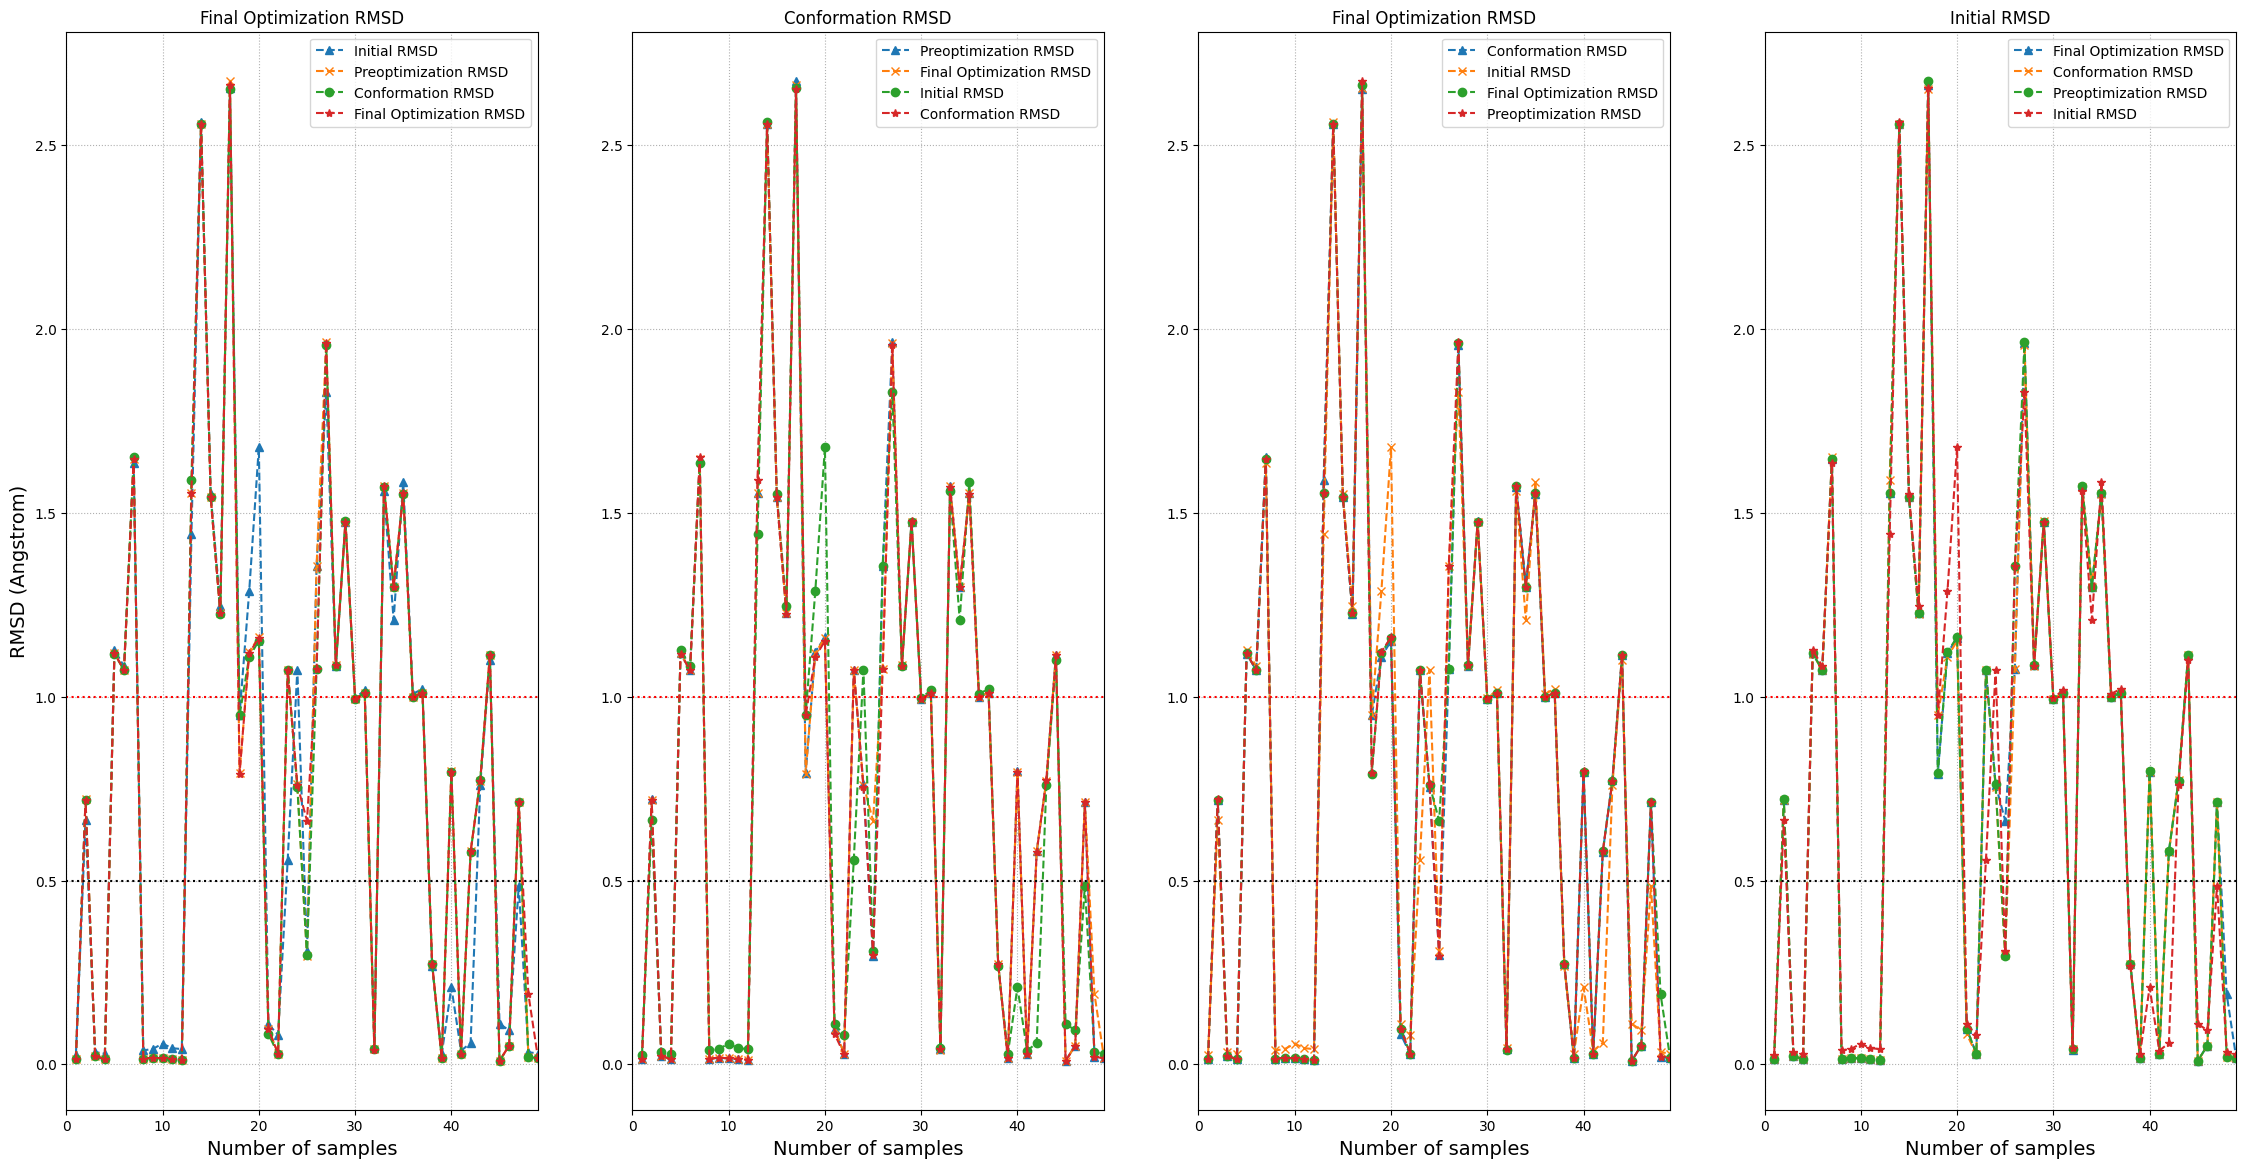

In [5]:

fig, axes = plt.subplots(1, 4, figsize=(28, 14))
lot0 = ['Initial RMSD','Preoptimization RMSD', 'Conformation RMSD', 'Final Optimization RMSD']
lot1 = ['Preoptimization RMSD', 'Final Optimization RMSD', 'Initial RMSD','Conformation RMSD']
lot2 = ['Conformation RMSD', 'Initial RMSD', 'Final Optimization RMSD','Preoptimization RMSD']
lot3 = ['Final Optimization RMSD', 'Conformation RMSD', 'Preoptimization RMSD','Initial RMSD']
labels = ['Final Optimization RMSD', 'Conformation RMSD', 'Final Optimization RMSD','Initial RMSD']
,
for lot0, lot1, lot2,lot3 ,label, ax in zip(lot0, lot1, lot2,lot3 ,labels, axes):
    
    ax.plot(cep_struc_devs_df[lot0][1:50], '--^', label=lot0)
    ax.plot(cep_struc_devs_df[lot1][1:50], '--x', label=lot1)
    ax.plot(cep_struc_devs_df[lot2][1:50], '--o', label=lot2)
    ax.plot(cep_struc_devs_df[lot3][1:50], '--*', label=lot3)
    ax.axhline(y = 0.5, color = 'k', linestyle = ':')
    ax.axhline(y = 1, color = 'r', linestyle = ':')
    ax.grid(linestyle=':')
    ax.set_xlim([0, len(cep_struc_devs_df[lot0][1:50])])

    ax.set_title("{}".format(label))
    
    ax.legend(loc='best')
    ax.set_xlabel('Number of samples', fontsize=14)
axes[0].set_ylabel('RMSD (Angstrom)', fontsize=14)

### **Processing Feature: Computation Time**

### **Practical Deviation Visualization: $\quad \texttt{cep}_{\texttt{Id=8025}} \quad$ sample**

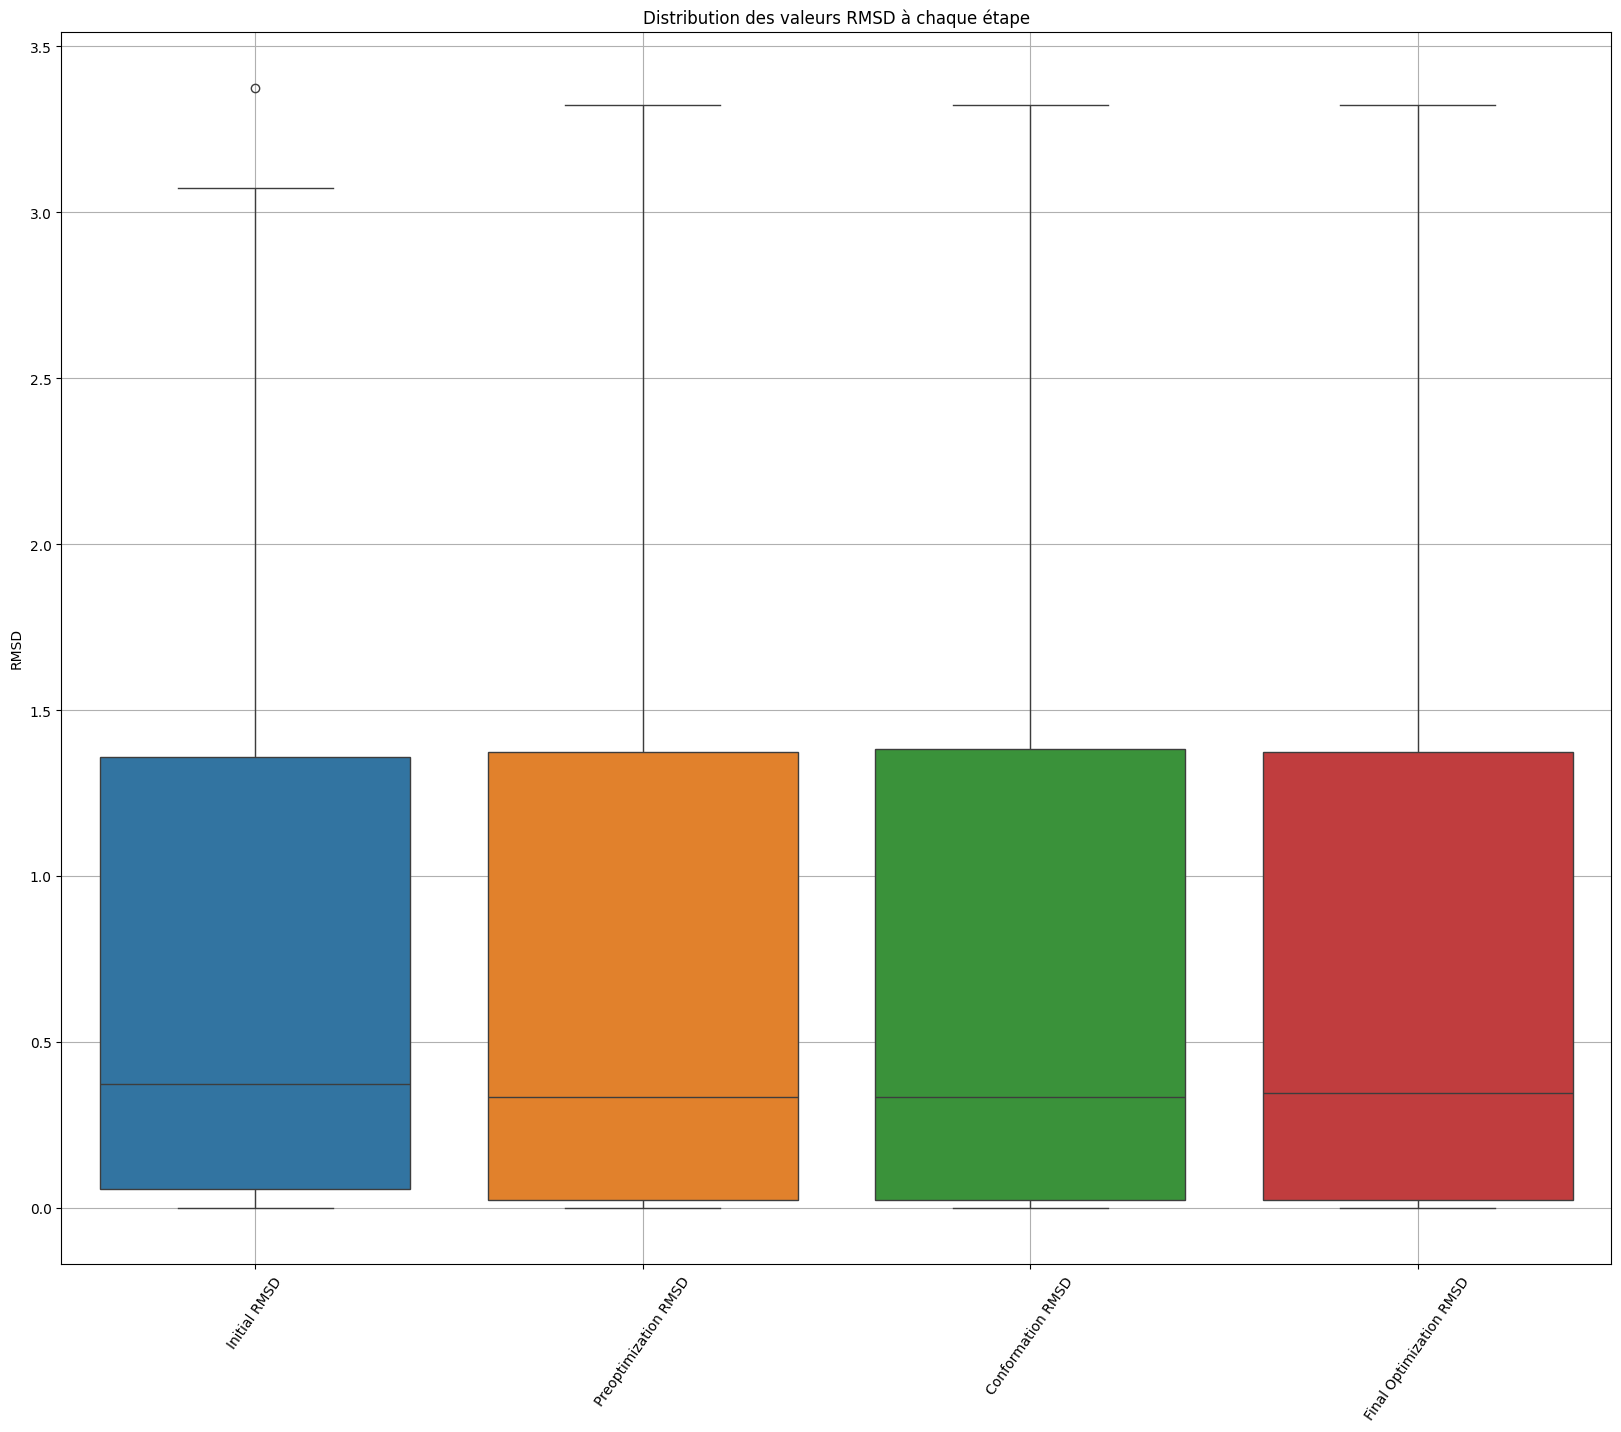

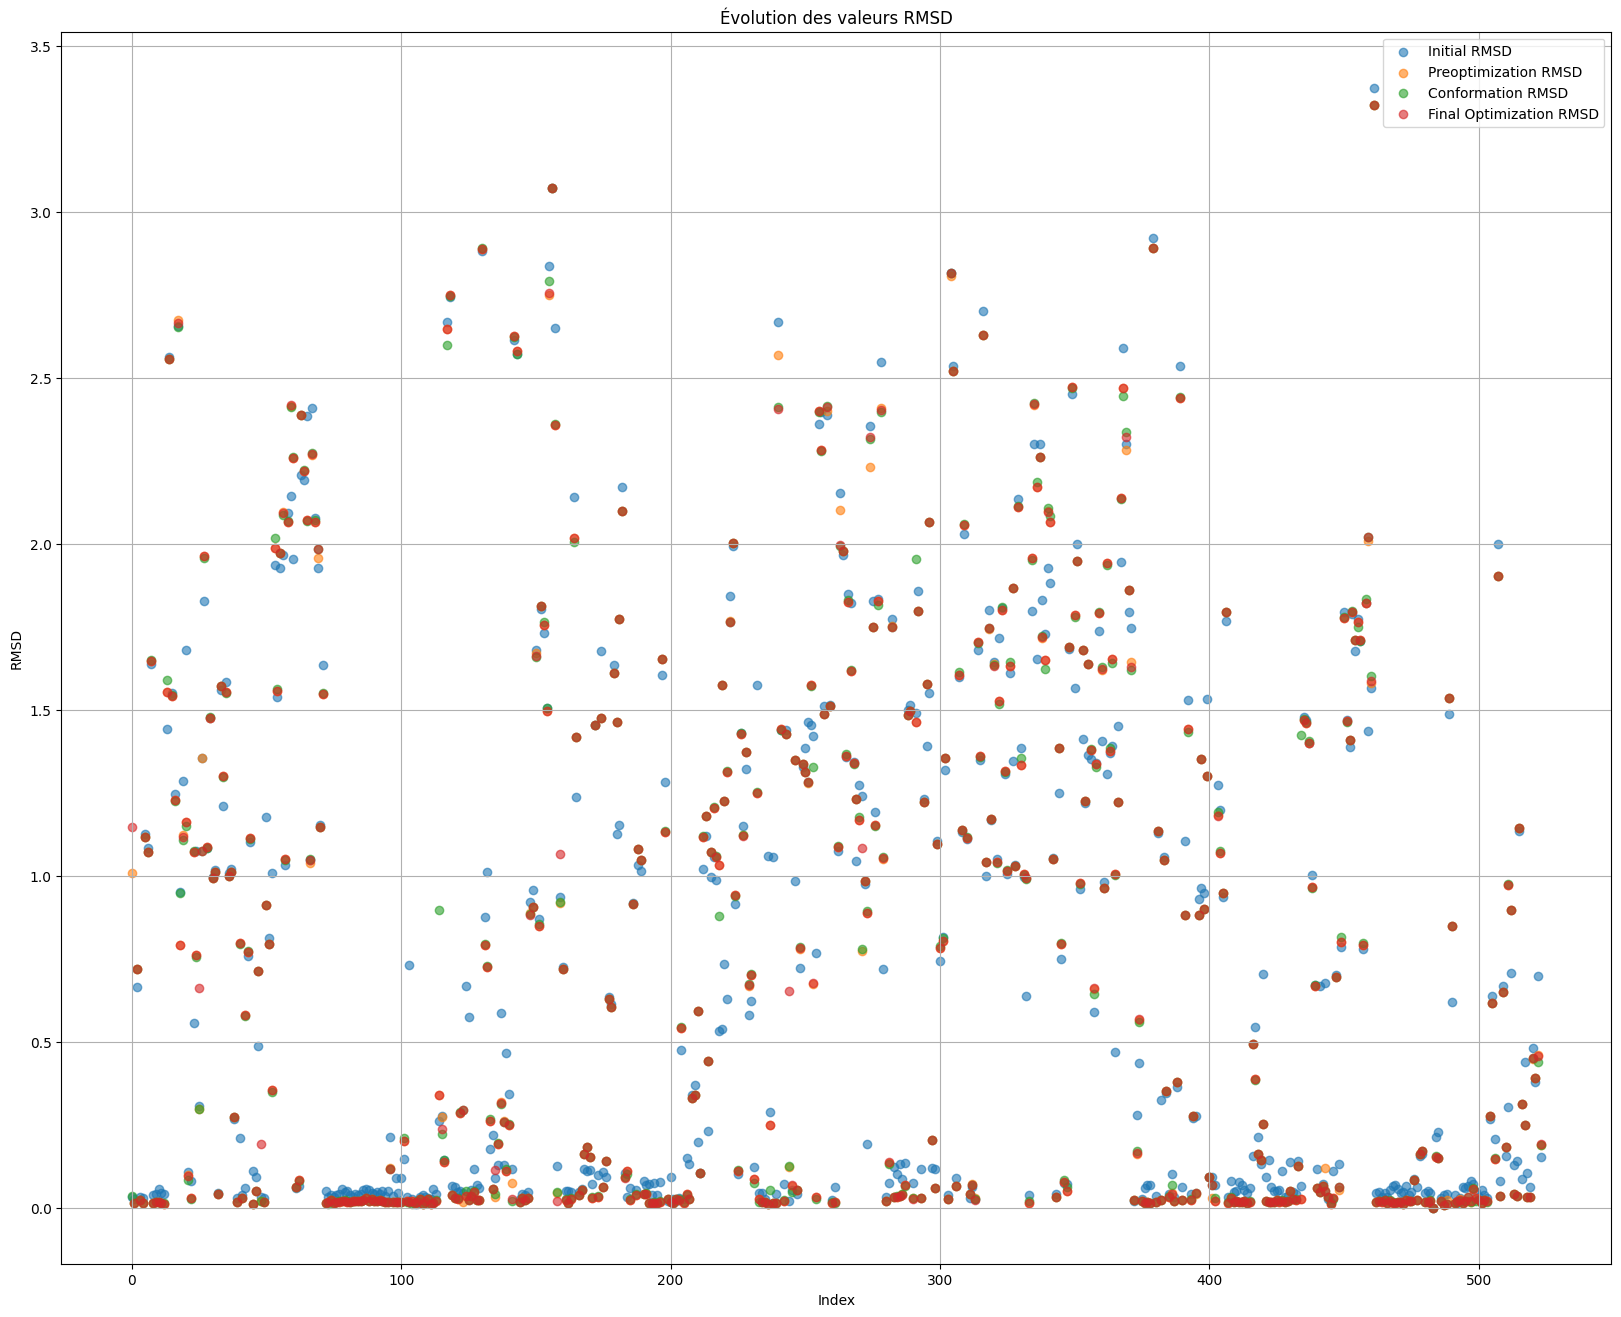

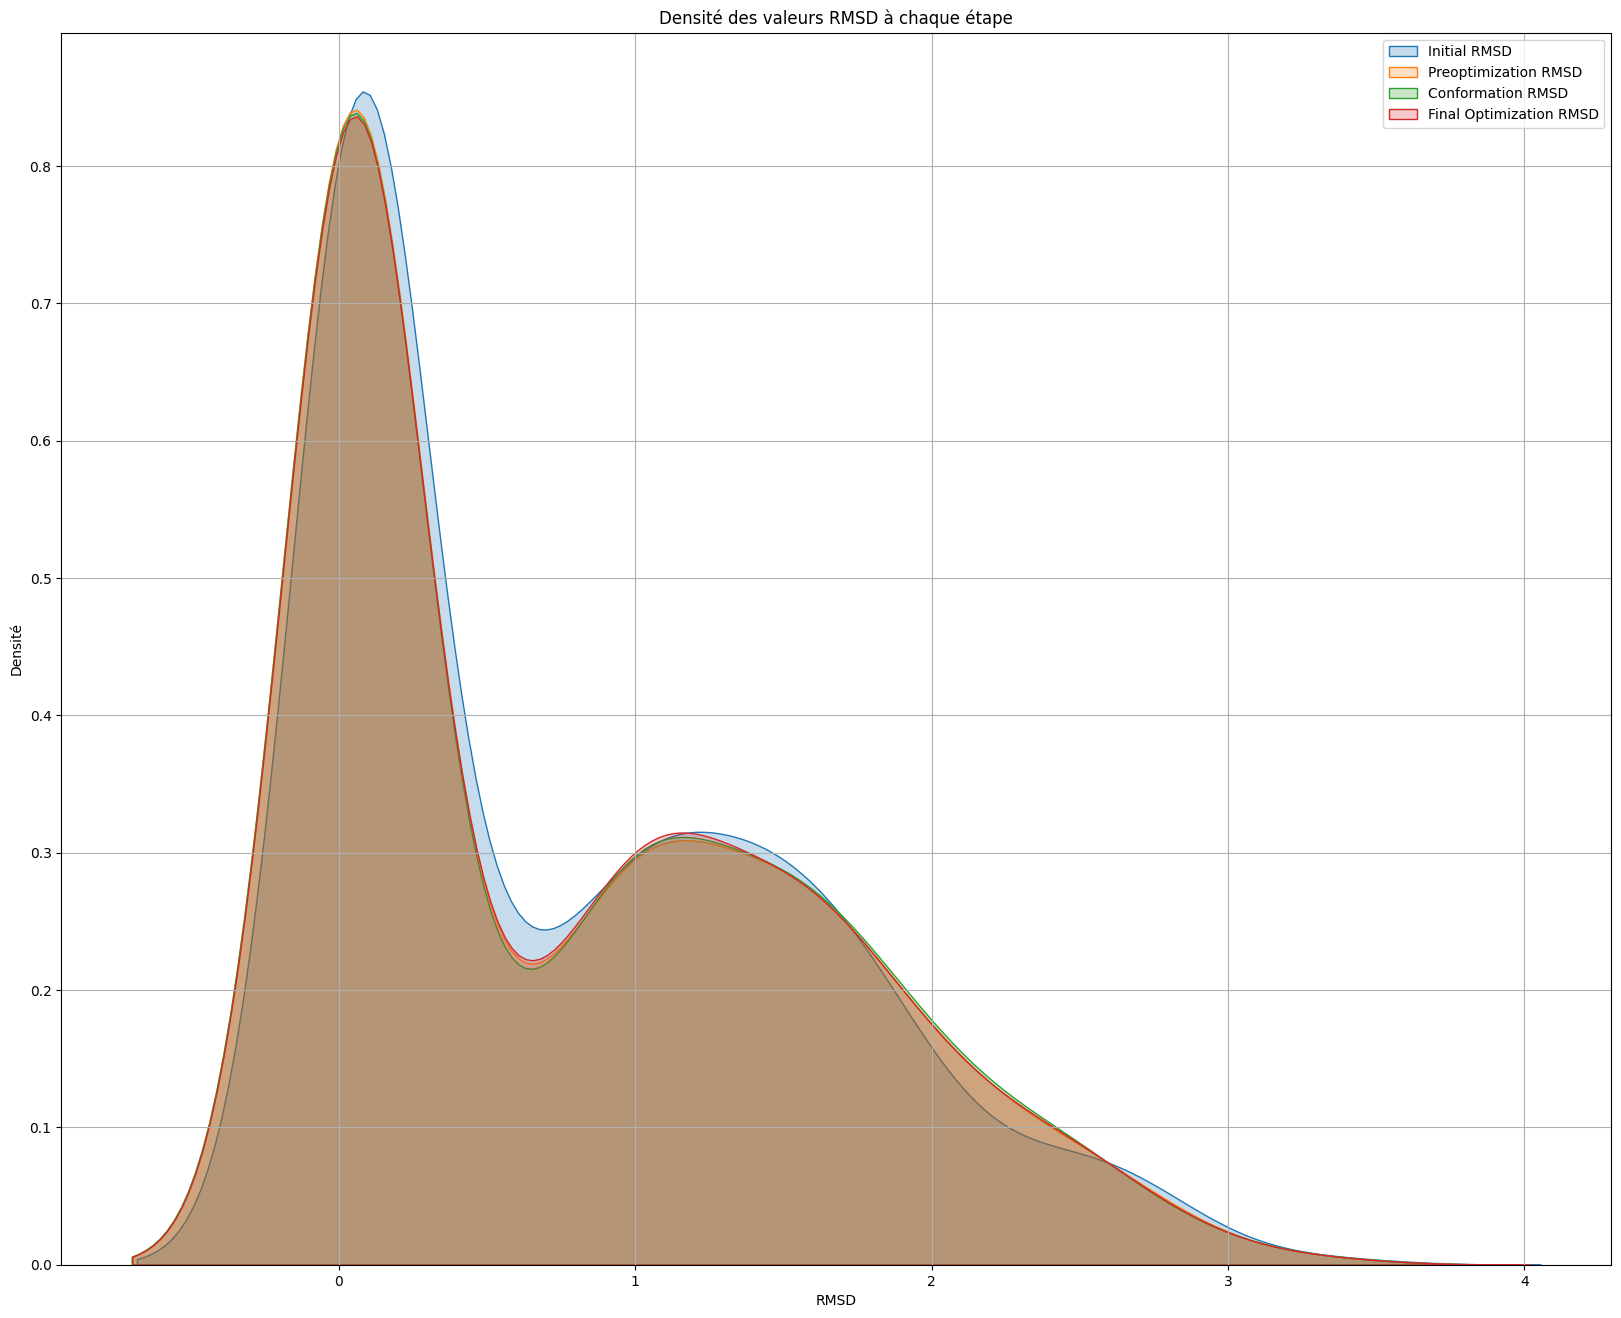

In [6]:
# Renommer les colonnes pour plus de lisibilité (optionnel)
df=cep_struc_devs_df
df.columns = ["Initial RMSD", "Preoptimization RMSD", "Conformation RMSD", "Final Optimization RMSD"]

# 1️⃣ Boxplot pour comparer la distribution des RMSD à chaque étape
plt.figure(figsize=(20, 16))
sns.boxplot(data=df)
plt.title("Distribution des valeurs RMSD à chaque étape")
plt.ylabel("RMSD")
plt.xticks(rotation=55)
plt.grid()
plt.show()

# 2️⃣ Nuage de points pour observer la dispersion
plt.figure(figsize=(20, 16))
for col in df.columns:
    plt.scatter(range(len(df)), df[col], alpha=0.6, label=col)
plt.legend()
plt.title("Évolution des valeurs RMSD")
plt.xlabel("Index")
plt.ylabel("RMSD")
plt.grid()
plt.show()

# 3️⃣ Densité des valeurs RMSD (courbes KDE) - Correction
plt.figure(figsize=(20, 16))
for col in df.columns:
    sns.kdeplot(df[col], label=col, fill=True)  # Remplace shade=True par fill=True
plt.title("Densité des valeurs RMSD à chaque étape")
plt.xlabel("RMSD")
plt.ylabel("Densité")
plt.legend()
plt.grid()
plt.show()

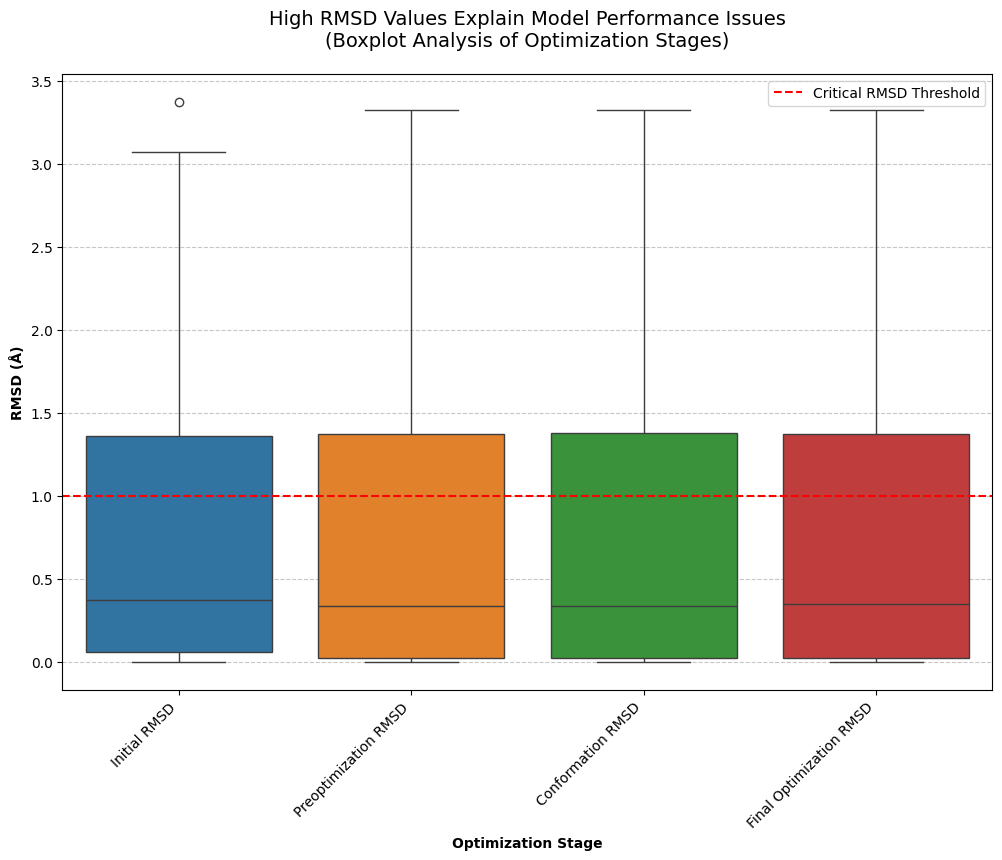

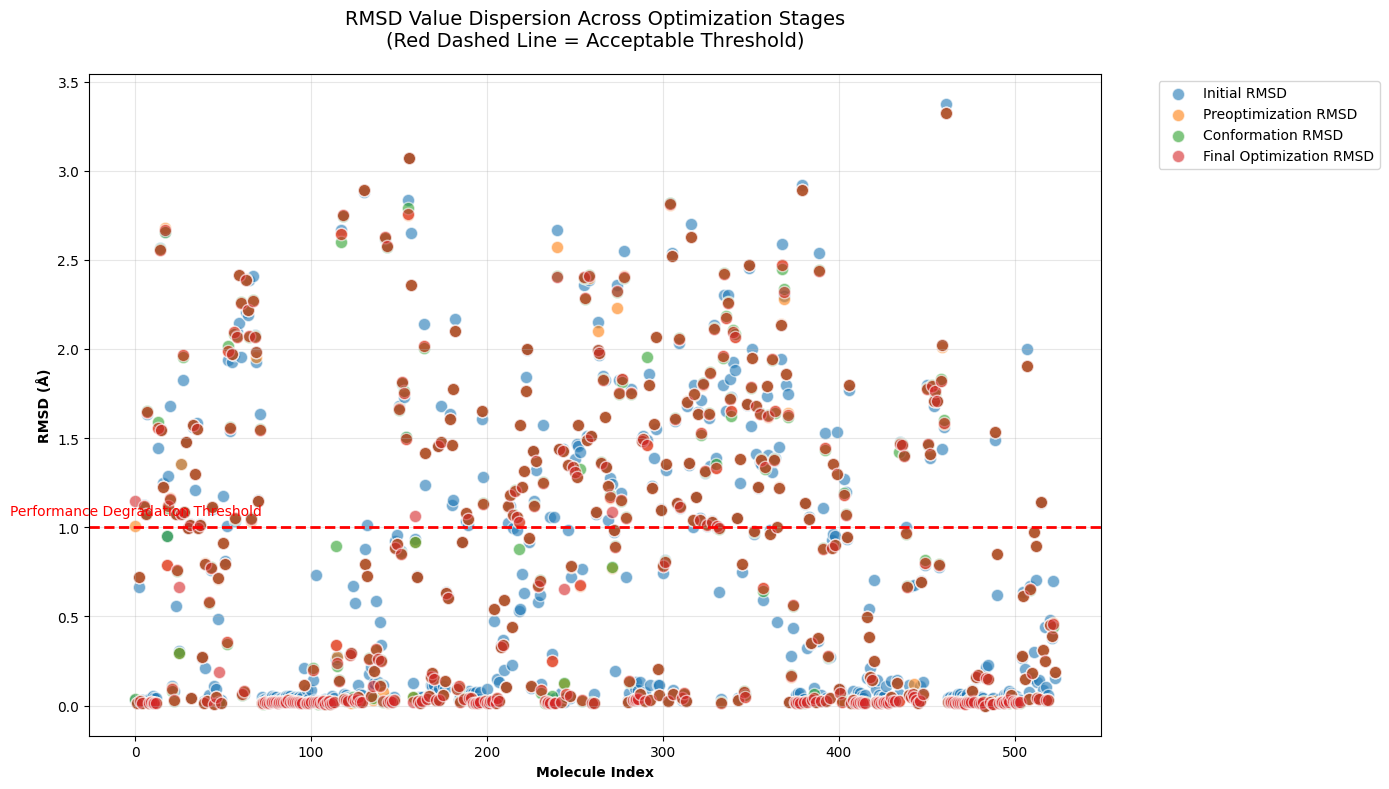

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1️⃣ Boxplot comparatif avec analyse des outliers
plt.figure(figsize=(12, 8))
sns.boxplot(data=df)
plt.title("High RMSD Values Explain Model Performance Issues\n"
          "(Boxplot Analysis of Optimization Stages)", fontsize=14, pad=20)
plt.ylabel("RMSD (Å)", fontweight='bold')
plt.xlabel("Optimization Stage", fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axhline(y=1.0, color='r', linestyle='--', linewidth=1.5, 
            label='Critical RMSD Threshold')
plt.legend()
plt.show()

# 2️⃣ Dispersion des valeurs avec mise en évidence des problèmes
plt.figure(figsize=(14, 8))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
for i, col in enumerate(df.columns):
    plt.scatter(df.index, df[col], alpha=0.6, color=colors[i], 
                label=col, s=80, edgecolor='w')
plt.title("RMSD Value Dispersion Across Optimization Stages\n"
          "(Red Dashed Line = Acceptable Threshold)", fontsize=14, pad=20)
plt.xlabel("Molecule Index", fontweight='bold')
plt.ylabel("RMSD (Å)", fontweight='bold')
plt.axhline(y=1.0, color='r', linestyle='--', linewidth=2)
plt.text(x=0.5, y=1.05, s='Performance Degradation Threshold', 
         color='r', va='bottom', ha='center')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



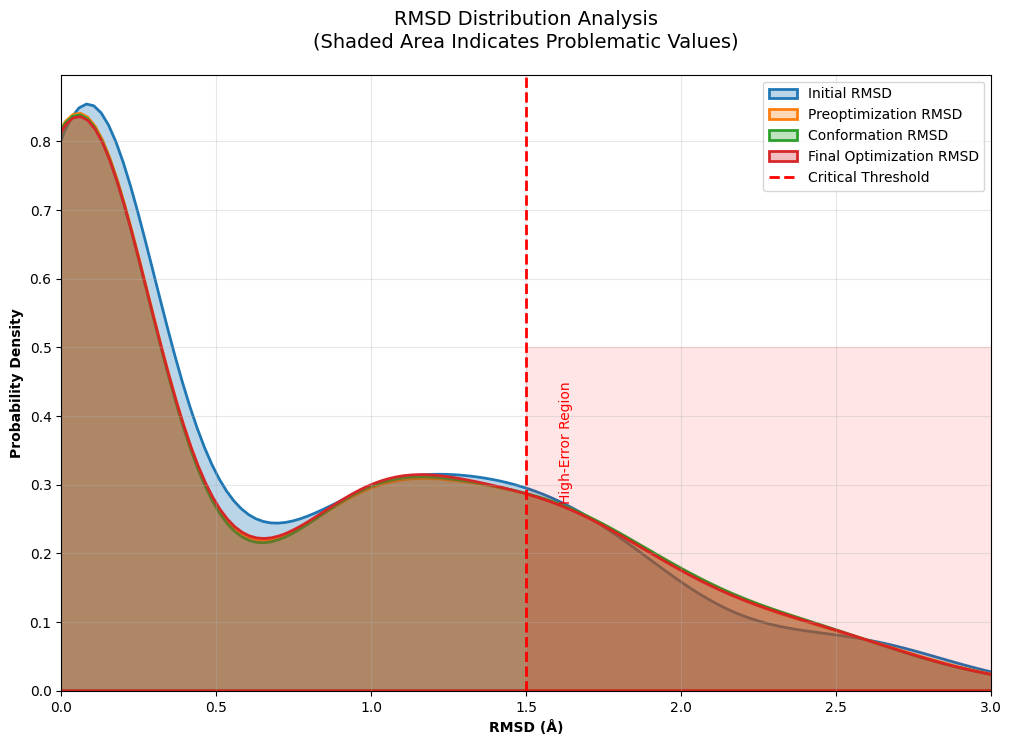

In [8]:
# 3️⃣ Analyse de distribution avec zone critique
plt.figure(figsize=(12, 8))
for col in df.columns:
    sns.kdeplot(df[col], label=col, fill=True, alpha=0.3, linewidth=2)
plt.title("RMSD Distribution Analysis\n"
          "(Shaded Area Indicates Problematic Values)", fontsize=14, pad=20)
plt.xlabel("RMSD (Å)", fontweight='bold')
plt.ylabel("Probability Density", fontweight='bold')
plt.axvline(x=1.5, color='r', linestyle='--', linewidth=2, 
            label='Critical Threshold')
plt.fill_betweenx(y=[0, 0.5], x1=1.5, x2=3.0, color='red', alpha=0.1)
plt.text(x=1.65, y=0.45, s='High-Error Region', rotation=90, color='r', 
         va='top', ha='right')
plt.xlim(0, 3)
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('rmsd_distribution_analysis.pdf', dpi=300)
plt.show()

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Création de la figure
plt.figure(figsize=(12, 8), dpi=300)  # Résolution augmentée
for col in df.columns:
    sns.kdeplot(df[col], label=col, fill=True, alpha=0.3, linewidth=2)

# Configuration du style
plt.title("RMSD Distribution Analysis\n(Shaded Area Indicates Problematic Values)", 
          fontsize=14, pad=20, fontweight='bold')
plt.xlabel("RMSD (Å)", fontweight='bold')
plt.ylabel("Probability Density", fontweight='bold')
plt.axvline(x=1.0, color='r', linestyle='--', linewidth=2, label='Critical Threshold')
plt.fill_betweenx(y=[0, 0.5], x1=1.0, x2=3.0, color='red', alpha=0.1)
plt.text(x=1.15, y=0.45, s='High-Error Region', rotation=90, color='r', 
         va='top', ha='right', fontsize=10)
plt.xlim(0, 3)
plt.legend(frameon=False, fontsize=10)
plt.grid(alpha=0.3)

# Sauvegarde en PDF avec paramètres professionnels
plt.savefig('rmsd_distribution_analysis.pdf', 
            format='pdf', 
            bbox_inches='tight', 
            transparent=False,
            metadata={
                'Title': 'RMSD Distribution Analysis',
                'Author': 'Your Name',
                'Subject': 'Structural Optimization QC Analysis',
                'Keywords': 'RMSD, DFT, Molecular Optimization'
            })

plt.close()  # Fermeture propre de la figure

In [7]:
import pandas as pd
cep_struc_devs_df = pd.read_csv('gdb9_structure_deviations.csv')
cep_struc_devs_df

,Initial RMSD,Preoptimization RMSD,Conformation RMSD,Final Optimization RMSD
0,0.031040,1.008820,0.035259,1.147324
1,0.026825,0.014931,0.015236,0.014954
2,0.665131,0.720764,0.720147,0.720281
3,0.033651,0.023466,0.023677,0.023351
4,0.028954,0.013412,0.013713,0.013428
...,...,...,...,...
519,0.061774,0.031929,0.032110,0.031965
520,0.482233,0.449526,0.450228,0.449840
521,0.378438,0.390454,0.391524,0.390405
522,0.698082,0.460748,0.440522,0.457166


In [8]:
show_structure_file('./xTB_OPT_SDF/gdb 129205_xtb_opt.sdf')

NGLWidget()

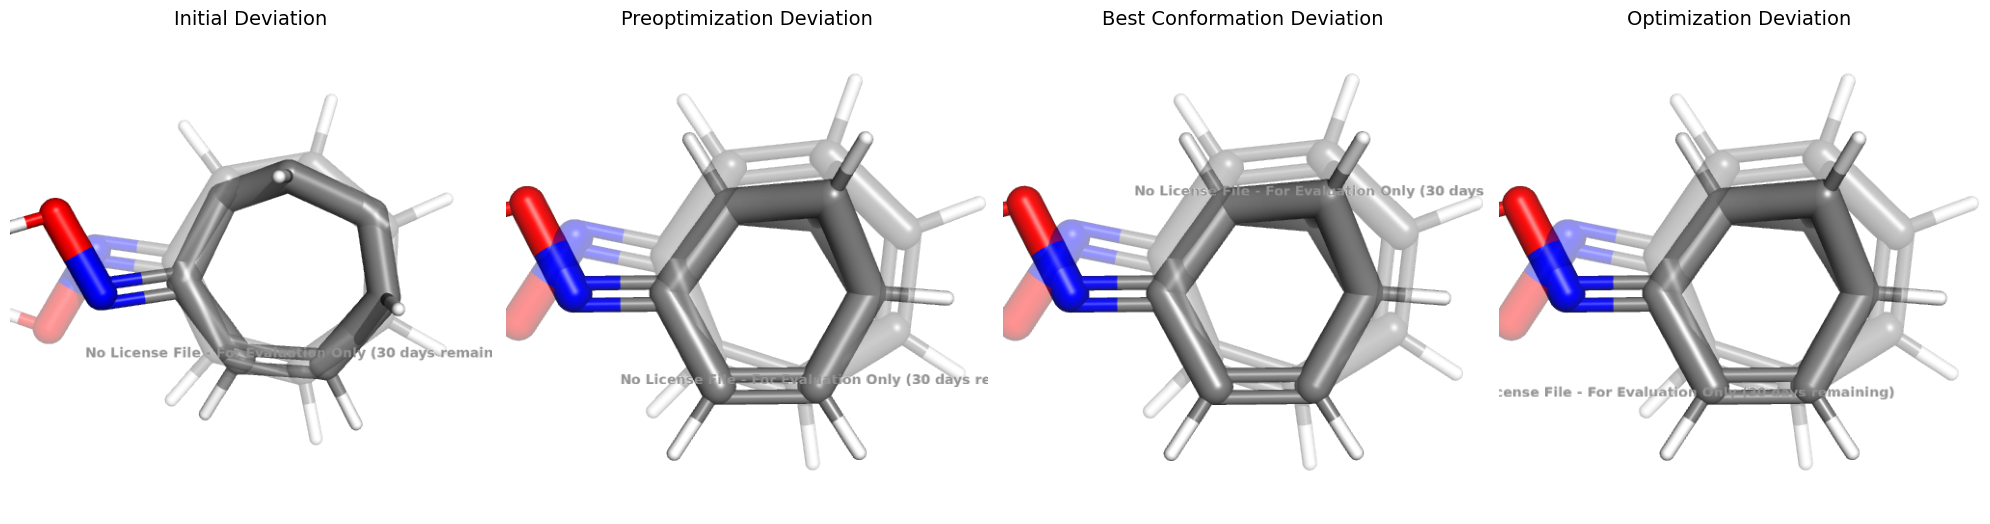

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Liste des chemins des images
image_paths = [
    "./images/cep_22001_gfn2_Initial_deviation.png",
    "./images/cep_22001_gfn2_preoptimization_deviation.png",
    "./images/cep_22001_gfn2_best_conformation_deviation.png",
    "./images/gdb_22001_gfn2_optimization_deviation.png"
]

# Titres correspondants à chaque image
titles = [
    "Initial Deviation",
    "Preoptimization Deviation",
    "Best Conformation Deviation",
    "Optimization Deviation"
]

# Créer une figure avec 4 sous-graphiques sur une ligne
fig, axes = plt.subplots(1, 4, figsize=(20, 7))  # 1 ligne, 4 colonnes

# Charger, afficher chaque image et ajouter un titre
for ax, img_path, title in zip(axes, image_paths, titles):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis("off")  # Cacher les axes
    ax.set_title(title, fontsize=14)  # Ajouter un titre

# Ajuster l'affichage pour éviter le chevauchement
plt.tight_layout()
plt.show()
with PdfPages('rmsd_visualizations1.pdf') as pdf:
    pdf.savefig(fig)

### **Quantum Chemistry Results**

* **Total Energy (KCal/mol) Visualization**

<div class="alert alert-success">
    <h2>Conclusion</h2>
    Based on the observations above, the three members of the <code>GFNn</code> family are producing consistent and converging results, at least for the samples we've tested. This provides us with a valuable starting point, stating that the ability to switch between the methods in case of errors in preoptimization or conformer search steps for a particular sample seems reasonable, as the methods appears to be yielding similar final results. 
    But, can we definitely say our analyses remain <bold>true</bold> for all the samples in the databases investigated above, containing either small organic molecules (<code>QM9</code>) or medium sized organic semiconductors (<code>cep</code> and <code>hce</code>)?
</div>

<div class="alert alert-warning">
    <h2>Further Improvement</h2>
    In order to thoroughly validate the switching mechanism with a larger sample set to ensure the consistency and reliability of the analyses above:
    <ol>
        <li>Increase the size of the sample set to ensure the results hold true for a larger portion of the dataset.</li>
        <li>Ensure the molecules in our sample set are truly representative of the full dataset, covering the range of molecular complexities, for the switching mechanism to remain reliable as the distribution and characteristics of the samples may vary.</li>
        <li>Identify edge cases, i.e. potential outlier samples where the methods diverge significantly by monitoring RMSD values and try investigate the underlying causes.</li>
    </ol>
</div>

---
# **References**

<!-- BIBLIOGRAPHY START -->
<div class="csl-bib-body">
  <div class="csl-entry"><i id="zotero|9235801/CE7AEM4H"></i>
    <div class="csl-left-margin">[1]</div><div class="csl-right-inline">A. Nigam <i>et al.</i>, “Tartarus: A Benchmarking Platform for Realistic And Practical Inverse Molecular Design.” arXiv, 11-Oct-2023 [Online]. Available: <a href="http://arxiv.org/abs/2209.12487">http://arxiv.org/abs/2209.12487</a>. [Accessed: 23-Oct-2023]</div>
  </div>
  <div class="csl-entry"><i id="zotero|9235801/R4KPWEEQ"></i>
    <div class="csl-left-margin">[2]</div><div class="csl-right-inline">R. Ramakrishnan, P. O. Dral, M. Rupp, and O. A. Von Lilienfeld, “Quantum chemistry structures and properties of 134 kilo molecules,” <i>Sci Data</i>, vol. 1, no. 1, p. 140022, Aug. 2014, doi: <a href="https://doi.org/10.1038/sdata.2014.22">10.1038/sdata.2014.22</a>. [Online]. Available: <a href="https://www.nature.com/articles/sdata201422">https://www.nature.com/articles/sdata201422</a>. [Accessed: 27-Oct-2023]</div>
  </div>
  <div class="csl-entry"><i id="zotero|9235801/SMKLYZLC"></i>
    <div class="csl-left-margin">[3]</div><div class="csl-right-inline">J. Hachmann <i>et al.</i>, “The Harvard Clean Energy Project: Large-Scale Computational Screening and Design of Organic Photovoltaics on the World Community Grid,” <i>J. Phys. Chem. Lett.</i>, vol. 2, no. 17, pp. 2241–2251, Sep. 2011, doi: <a href="https://doi.org/10.1021/jz200866s">10.1021/jz200866s</a>. [Online]. Available: <a href="https://pubs.acs.org/doi/10.1021/jz200866s">https://pubs.acs.org/doi/10.1021/jz200866s</a>. [Accessed: 13-Nov-2023]</div>
  </div>
  <div class="csl-entry"><i id="zotero|9235801/WINV4Q3F"></i>
    <div class="csl-left-margin">[4]</div><div class="csl-right-inline">C. Bannwarth <i>et al.</i>, “Extended <span style="font-variant:small-caps;">tight‐binding</span> quantum chemistry methods,” <i>WIREs Comput Mol Sci</i>, vol. 11, no. 2, p. e1493, 2021, doi: <a href="https://doi.org/10.1002/wcms.1493">10.1002/wcms.1493</a>. [Online]. Available: <a href="https://wires.onlinelibrary.wiley.com/doi/10.1002/wcms.1493">https://wires.onlinelibrary.wiley.com/doi/10.1002/wcms.1493</a>. [Accessed: 09-Aug-2024]</div>
  </div>
</div>
<!-- BIBLIOGRAPHY END -->